# Global Food Shock Analysis - Work Trial

This is the jupyter notebook for showcasing the analysis for global yield using the data from:

Anderson, W., W. Baethgen, F. Capitanio, P. Ciais, G. Cunha, L. Goddard, B. Schauberger , K. Sonder, G. Podesta, M. van der Velde, L. You, and Y. Ru. 2022. Twentieth Century Crop Statistics, 1900-2017. Palisades, New York: NASA Socioeconomic Data and Applications Center (SEDAC). https://doi.org/10.7927/tmsp-sg82. Accessed 5th September 2023. 

Major objective is to derive yearly global yield decrease (considering wheat & maize separately) as well as food shock trends from 1900 till today, and to create in particular:
- world map with largest food shocks per country
- time-series of global yield decrease, including patterns/trends, & distribution plot for global yield decrease

TOC:
- ...






### import libraries & set paths

In [14]:
import openpyxl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import os
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sys

# define relevant paths
main_directory = '/media/nadinespy/NewVolume1/applications/ALLFED/work_trial/ALLFED-Global-Food-Shock-Analysis/'
pathin_data = main_directory+r'data/'
pathout_plots = main_directory+r'results/plots/'

# import source code
sys.path.append(main_directory)
os.chdir(main_directory)
from src import global_food_shocks as gfs

# use ALLFED style for plots
plt.style.use(main_directory+r'ALLFED.mplstyle')

### load & view the data

In [15]:
# load excel workbook
workbook = openpyxl.load_workbook(pathin_data+r'food-twentieth-century-crop-statistics-1900-2017-xlsx.xlsx')

# iterate through each sheet to have a look at what worksheets and columns 
# per worksheet are involved, and look into first rows of the data
for index, sheet_name in enumerate(workbook.sheetnames):
    
    # get the sheet by name
    worksheet = workbook[sheet_name]  

    # get the header row (1st or 2nd row - it's different for different worksheets)
    if index == 1:
        header_row = worksheet[1]
    else:
        header_row = worksheet[2]

    # extract column names
    column_names = [cell.value for cell in header_row] 

    # create dataframe and look into first rows
    df = pd.read_excel(pathin_data+r'food-twentieth-century-crop-statistics-1900-2017-xlsx.xlsx', 
                       sheet_name=sheet_name)  
    
    # print the sheet name, column names, and first rows of each worksheet
    print(f"sheet name: {sheet_name}")
    print("column names:", column_names)
    print("first rows of dataframe:")
    print(df.head())
    print()  # add a newline for clarity

sheet name: Title Page
column names: [None, None]
first rows of dataframe:
  Unnamed: 0                                         Unnamed: 1
0        NaN                                                NaN
1        NaN       Twentieth Century Crop Statistics, 1900-2017
2        NaN  https://sedac.ciesin.columbia.edu/data/set/foo...
3        NaN                                                NaN
4        NaN                                        August 2022

sheet name: CropStats
column names: [None, 'Harvest_year', 'admin0', 'admin1', 'crop', 'hectares (ha)', 'production (tonnes)', 'year', 'yield(tonnes/ha)', 'admin2', 'notes']
first rows of dataframe:
   Unnamed: 0  Harvest_year   admin0 admin1   crop  hectares (ha)  \
0           0          1902  Austria    NaN  wheat            NaN   
1           1          1903  Austria    NaN  wheat            NaN   
2           2          1904  Austria    NaN  wheat            NaN   
3           3          1905  Austria    NaN  wheat            NaN

## exploratory data analysis

### rename variables, extract relevant data & re-calculate missing values where possible 

- The 'CropStats' sheet contains all information we need - the relevant variables for our analysis are tonnes/ha (commonly used to analyse crop yield), as well as tonnes and hectares which we'll use later for aggregating data to a global scale. 

- Sometimes tonnes/ha, tonnes and/or hectares are missing, but if two of the three are given for some crop/country/region/year combination, then we can re-calculate it. 

- Some variables like 'admin0' or 'yield(tonnes/ha)' have ambiguous and/or problematic names (e.g., for saving), so we'll rename those more unequivocally/without backslashes or blank spaces. We also want to extract the data we're interested in, i.e., wheat & maize as crops, and years 1900-2018.

- Also, we'll replace remaining zeros or blank entries in our variables of interest with NaNs - those are likely dirty data/incorrect, as countries/regions will unlikely have had suddenly zero crop yield/tonnes/hectares in a particular year, espectially if before and after there was non-zero crop yield.

In [16]:
# extract crop stats worksheet - all information I need is in there
crop_stats_df = pd.read_excel(pathin_data+r'food-twentieth-century-crop-statistics-1900-2017-xlsx.xlsx', 
                              sheet_name='CropStats')  

# rename columns for convenience & to avoid problems in saving plots 
rename_mapping = {
    'admin0': 'country',
    'production (tonnes)': 'tonnes',
    'hectares (ha)': 'hectares',
    'yield(tonnes/ha)': 'yield_tonnes_per_ha',
    'admin1': 'region'
}
gfs.rename_columns(crop_stats_df, rename_mapping)

# extract only wheat & maize, as well as 1900-2018 data
crops = ['maize', 'wheat']
crop_mask = crop_stats_df['crop'].isin(crops)
crop_stats_df = crop_stats_df[crop_mask]

year_mask = (crop_stats_df['year'] >= 1900) & (crop_stats_df['year'] <= 2018)
crop_stats_df = crop_stats_df[year_mask]

# re-calculate missing tonnes, hectares or tonnes/ha where two of the three  
# variables exist for a given country/region/crop/year combination

# calculate tonnes where hectares and tonnes/ha exist, but tonnes don't
crop_stats_df = crop_stats_df.assign(tonnes=[row["tonnes"] 
                                         if not pd.isnull(row["tonnes"]) 
                                         else row["yield_tonnes_per_ha"]*row["hectares"] 
                                         for i, row in crop_stats_df.iterrows() ])

# calculate hectares where tonnes and tonnes/ha exist, but hectares don't
crop_stats_df = crop_stats_df.assign(hectares=[row["hectares"] 
                                         if not pd.isnull(row["hectares"]) 
                                         else row["tonnes"] / row["yield_tonnes_per_ha"] 
                                         for i, row in crop_stats_df.iterrows() ])

# calculate yield (tonnes/ha) where tonnes & hectares exist, but tonnes/ha doesn't
crop_stats_df['yield_tonnes_per_ha'] = crop_stats_df.apply(lambda row: 
    row['tonnes'] / row['hectares'] if (not pd.isna(row['tonnes']) and 
                                               not pd.isna(row['hectares']) and 
                                               row['tonnes'] != 0 and 
                                               row['hectares'] != 0 and
                                               pd.isna(row['yield_tonnes_per_ha'])) else 
                                               (0 if row['tonnes'] == 0 and row['hectares'] == 0 else row['yield_tonnes_per_ha']), axis=1
)

# replace all remaining zeros and empty entries with NaNs
columns_to_modify = ['yield_tonnes_per_ha', 'region', 'hectares', 'tonnes']
values_to_replace = ['', ' ', 0]
crop_stats_df = gfs.replace_values_in_columns(crop_stats_df, columns_to_modify, values_to_replace)

### aggregate over regions for particular country/year/crop combination & investigate missing values

- Looking further into crop_stats_df, we see that countries may have multiple time series for multiple regions, or that regions are NaNs or empty. As we're solely interested in country-level and global variables, we'll make our lives easier by aggregating over regions using the median (rather than the mean to be more robust w. r. t. outliers).

- Once aggregated, we plot missing percentages for median tonnes, hectares, and tonnes/ha - one time grouped by country, and one time grouped by year (see plots below) - to get an idea of how biased our results will be. 
    - missing data grouped by country:
        - tonnes/ha: most missing data for wheat in the Czech Republic, Finland, Belgium (roughly 10-20%)
        - tonnes: most missing data for wheat in Croatia, Czech Republic, Finland, Austria, Belgium (50-80%)
        - hectares: most missing data for wheat in Croatia, Czech Republic, Finland, Austria, Belgium (50-80%)
    - missing data grouped by year: 
        - tonnes/ha: most missing data for wheat from 1900 – 1920, and 1930 – 1945 (ranging roughly from 10 – 30%)
        - tonnes:  most missing data for wheat until 1960 (ranging roughly from 25-40%)
        - hectares:  most missing data for wheat until 1960 (ranging roughly from 25-40%)
    - --> portion of missing values not overly concerning for global yield (tonnes/ha), gets also further improved after interpolation (see below)

- We plot the distributions of median yield, one time grouped by country, one time grouped by 5-year periods (see plots below).
    - both plots grouped by either country or 5-year periods show strongly left-skewed distributions, sometimes bimodal

- We plot time-series of median tonnes/ha, both for each country as well as across countries with confidence intervals using seaborns bootstrapping functionality (see plots below).
    - both plots grouped by country or across countries: all increasing as a global trend, often variances increase over time for both crops

/media/nadinespy/NewVolume1/applications/ALLFED/work_trial/ALLFED-Global-Food-Shock-Analysis/src/global_food_shocks.py:115: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=x_label, y=variable, hue='crop', data=df, ci=None)


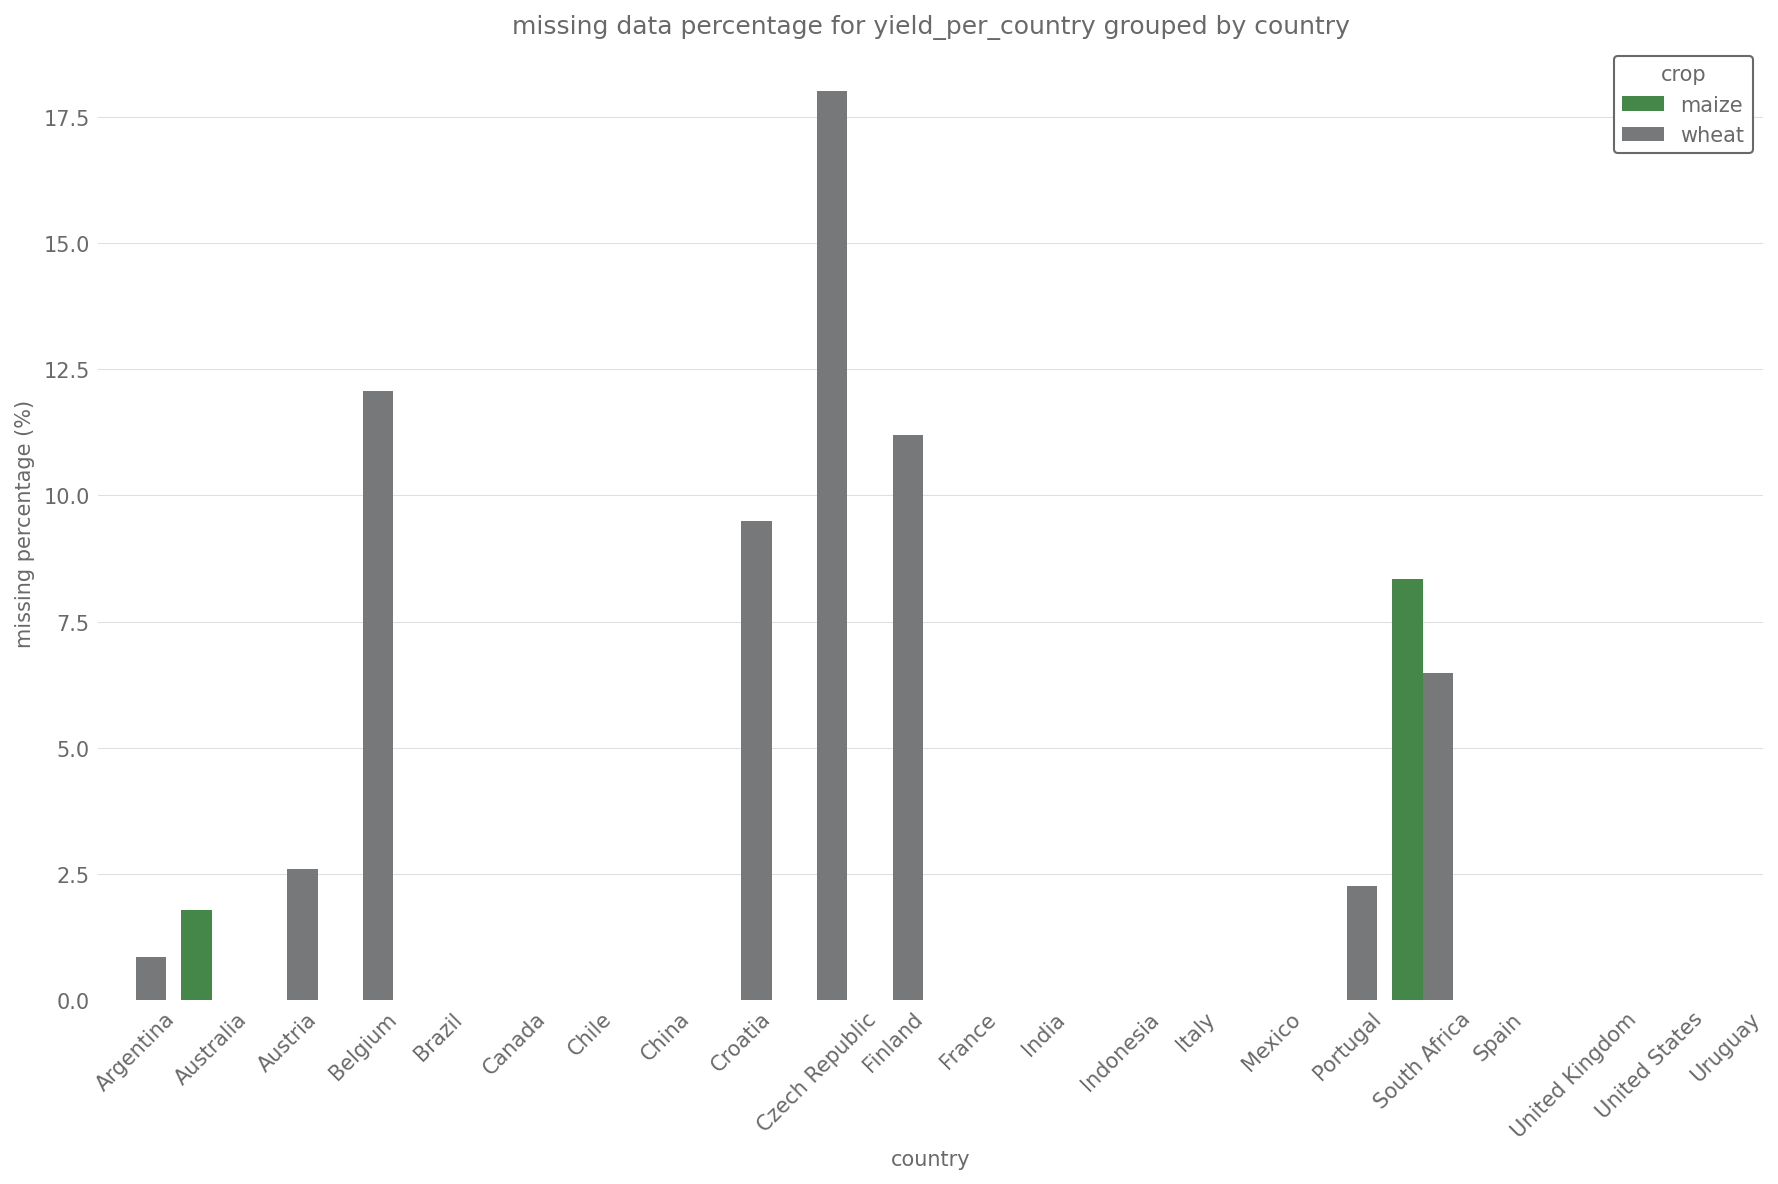

/media/nadinespy/NewVolume1/applications/ALLFED/work_trial/ALLFED-Global-Food-Shock-Analysis/src/global_food_shocks.py:115: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=x_label, y=variable, hue='crop', data=df, ci=None)


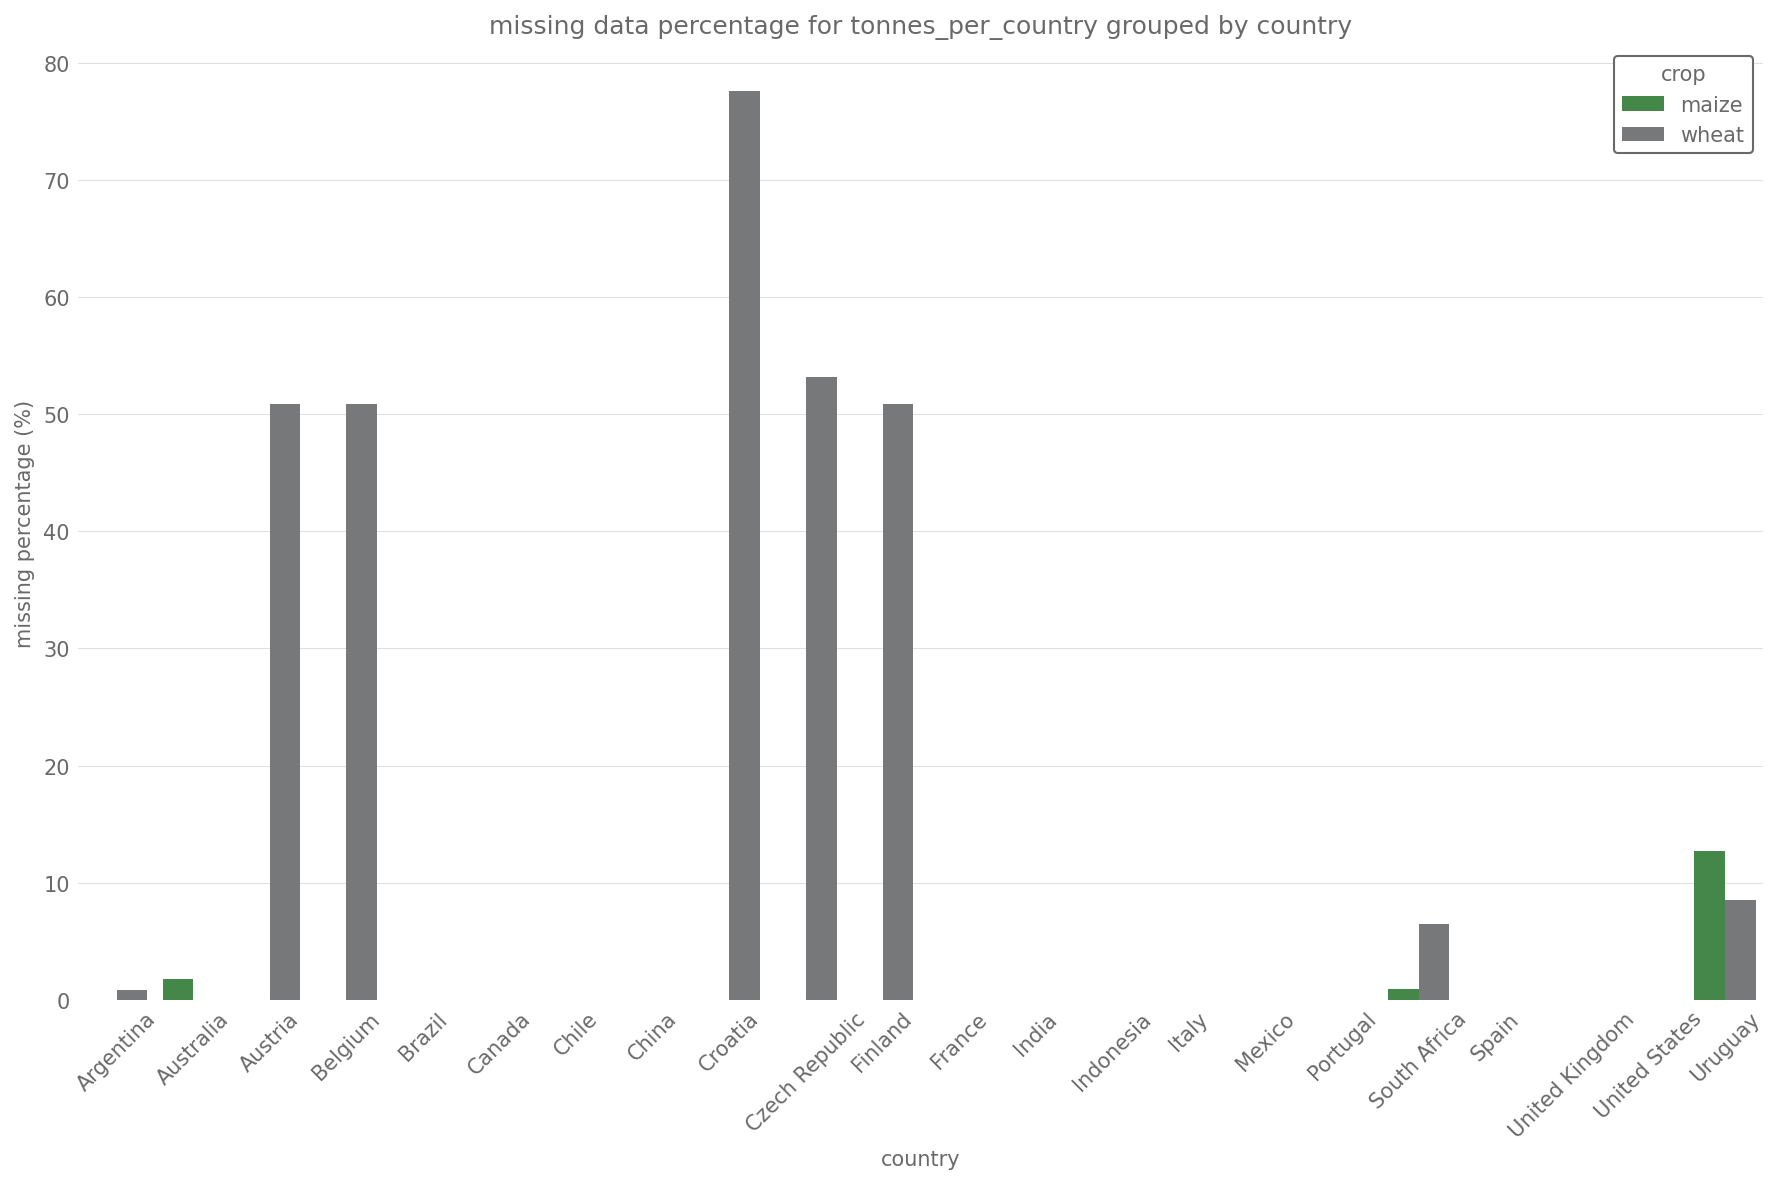

/media/nadinespy/NewVolume1/applications/ALLFED/work_trial/ALLFED-Global-Food-Shock-Analysis/src/global_food_shocks.py:115: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=x_label, y=variable, hue='crop', data=df, ci=None)


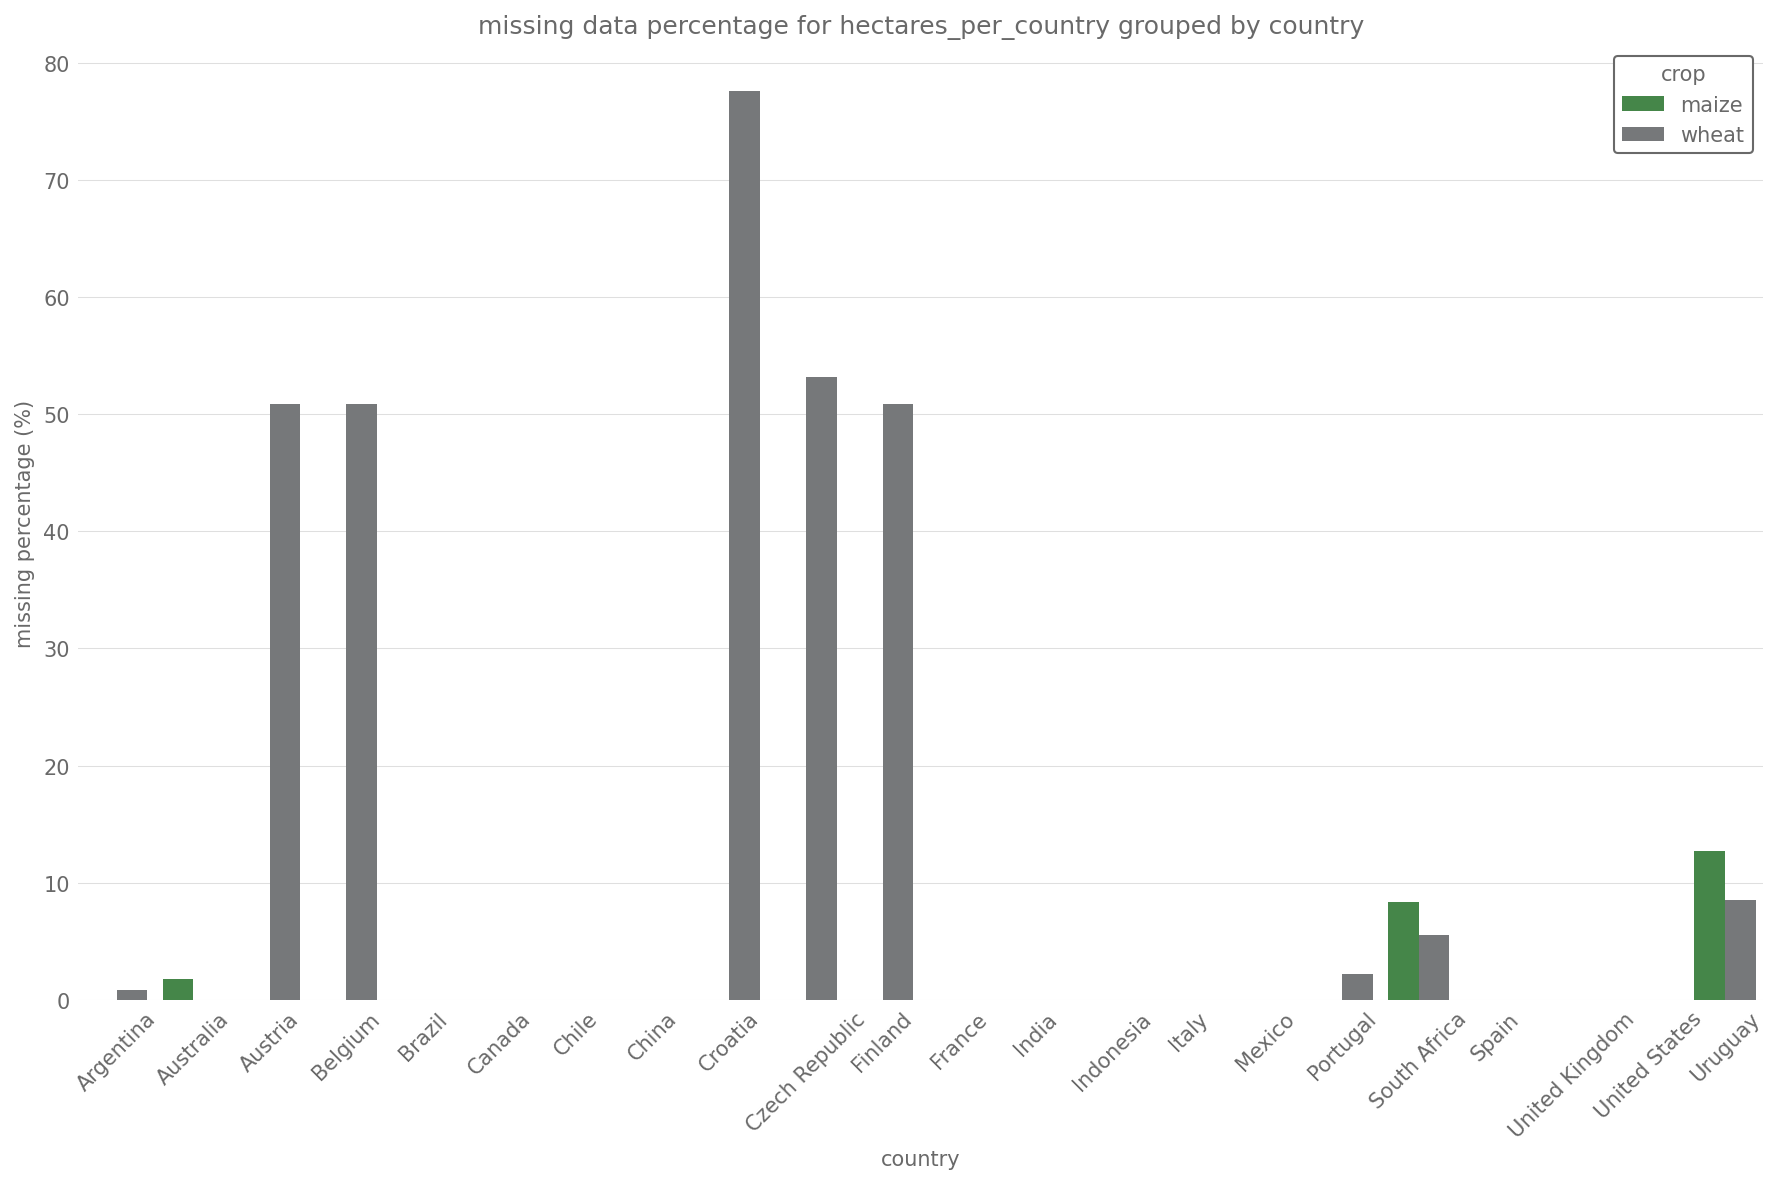

/media/nadinespy/NewVolume1/applications/ALLFED/work_trial/ALLFED-Global-Food-Shock-Analysis/src/global_food_shocks.py:115: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=x_label, y=variable, hue='crop', data=df, ci=None)


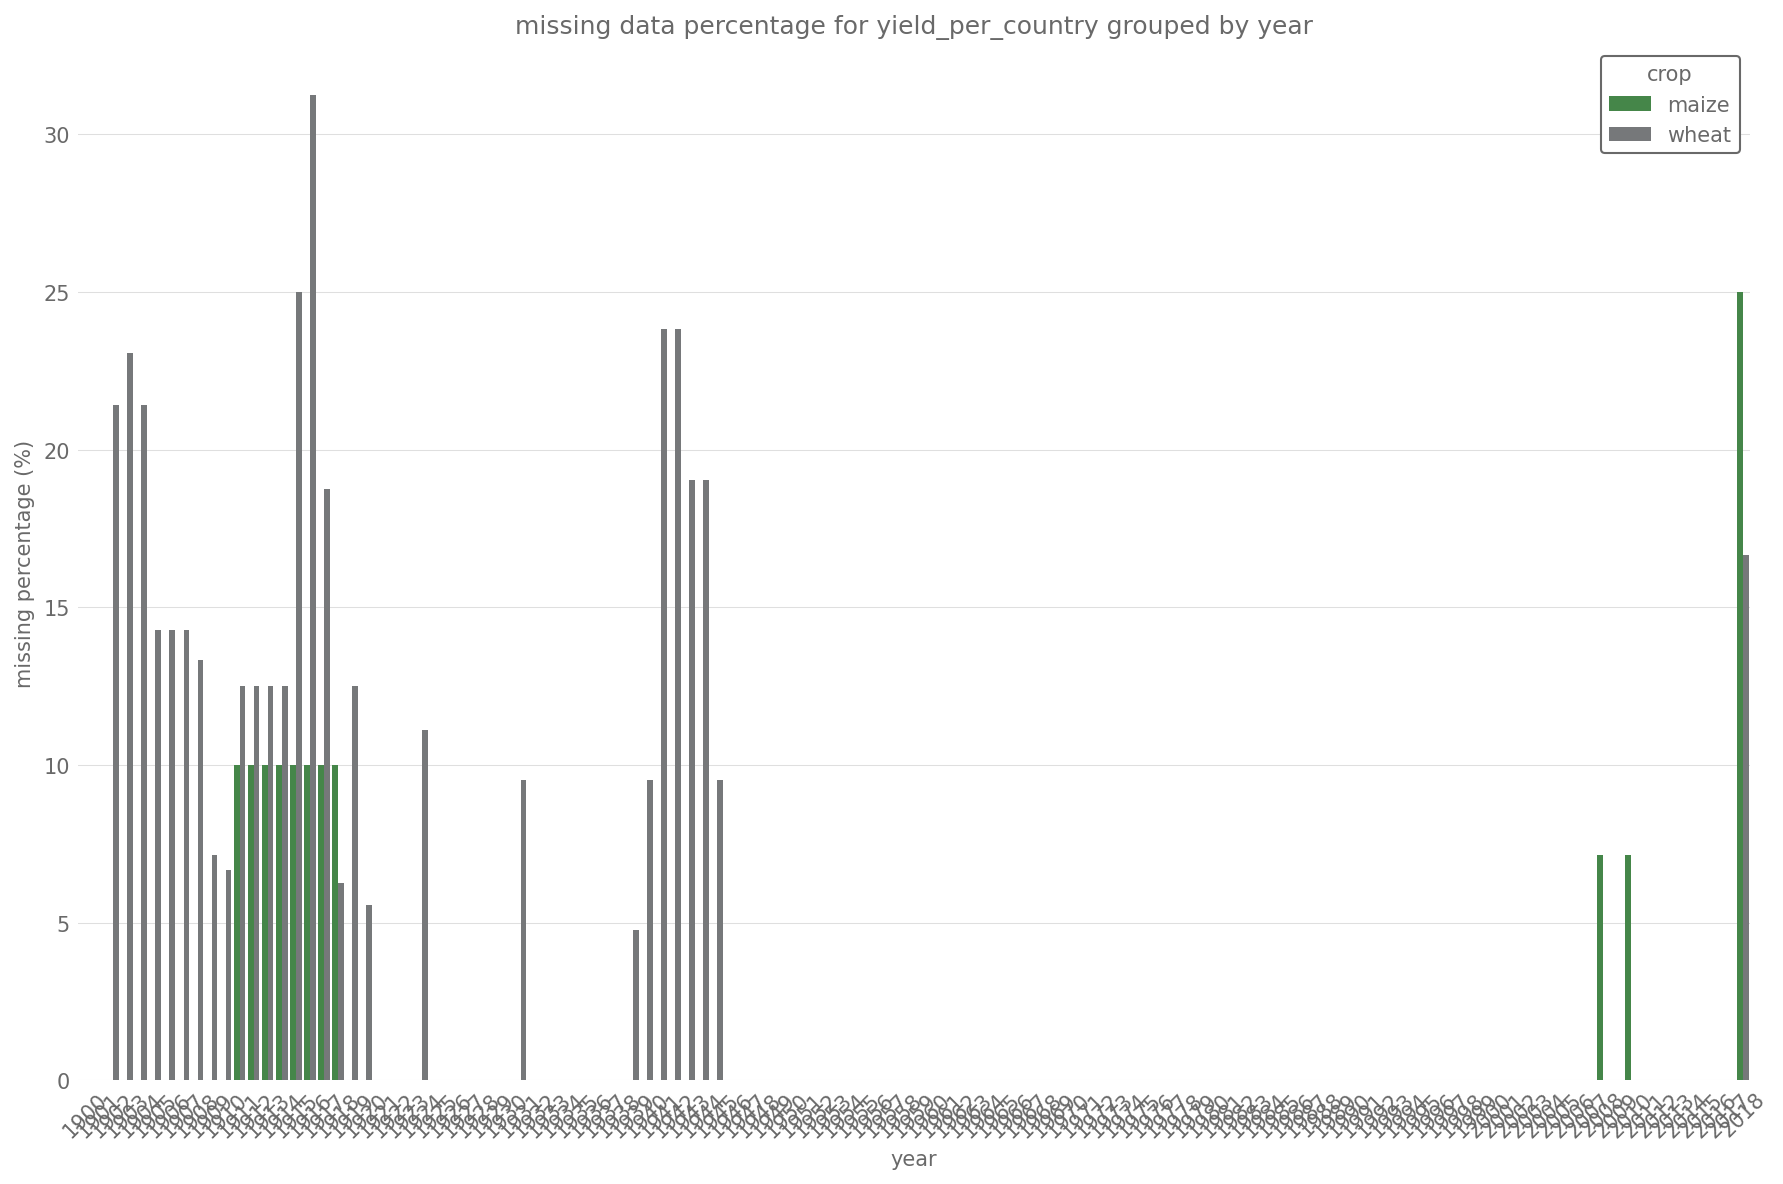

/media/nadinespy/NewVolume1/applications/ALLFED/work_trial/ALLFED-Global-Food-Shock-Analysis/src/global_food_shocks.py:115: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=x_label, y=variable, hue='crop', data=df, ci=None)


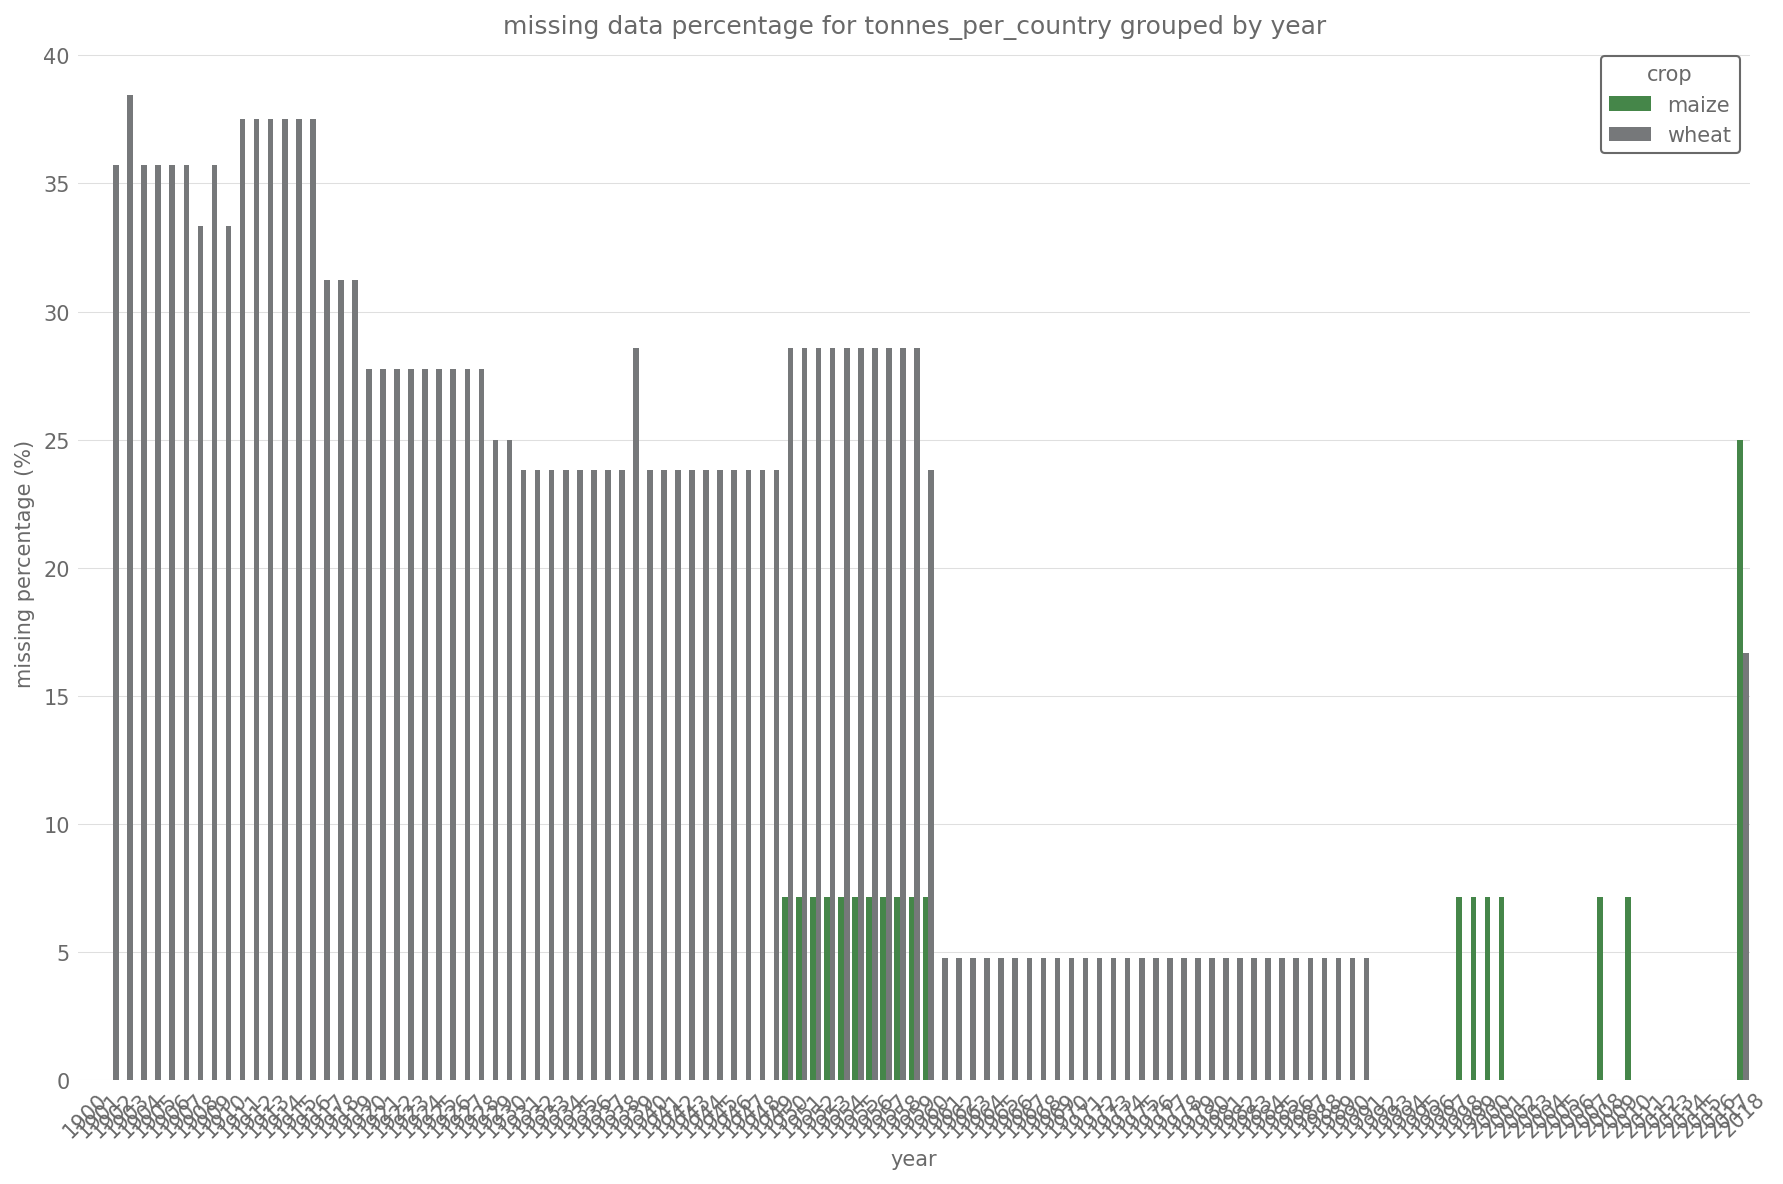

/media/nadinespy/NewVolume1/applications/ALLFED/work_trial/ALLFED-Global-Food-Shock-Analysis/src/global_food_shocks.py:115: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=x_label, y=variable, hue='crop', data=df, ci=None)


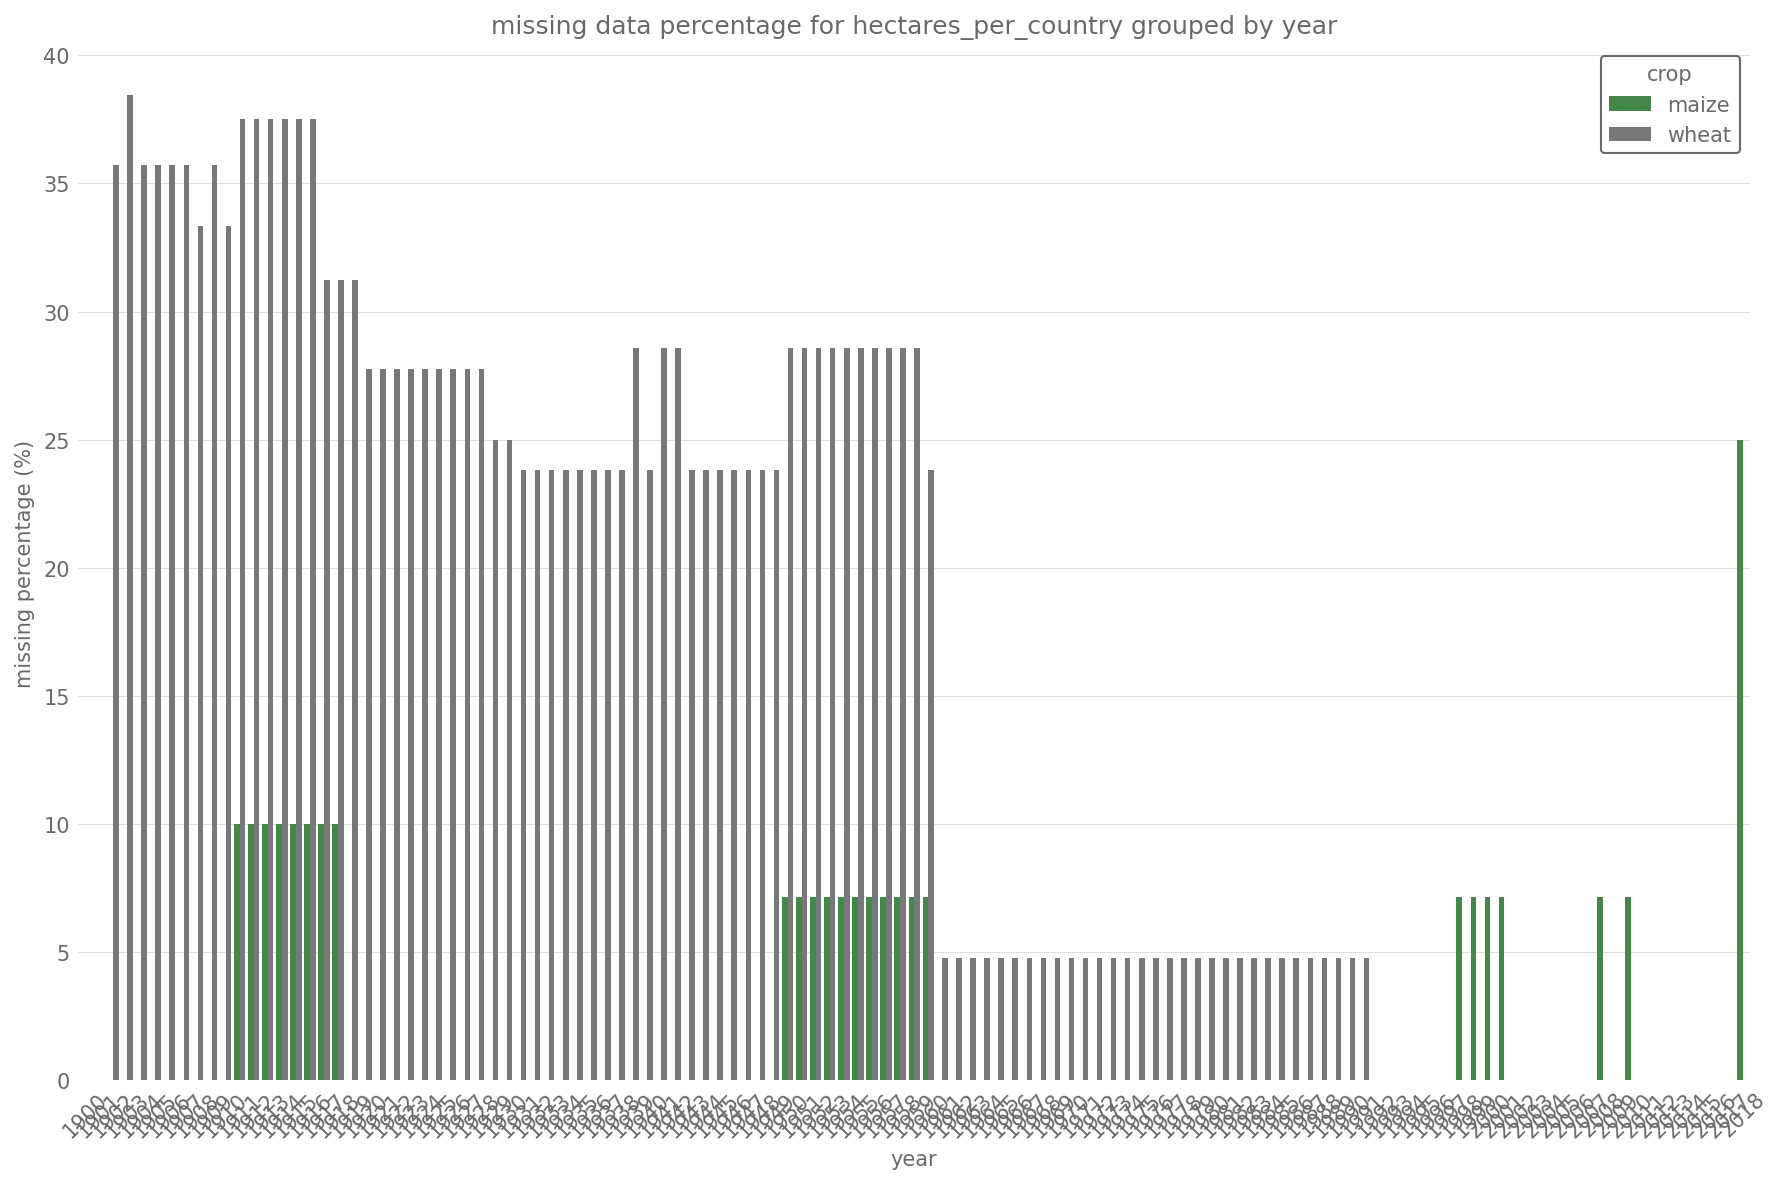

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

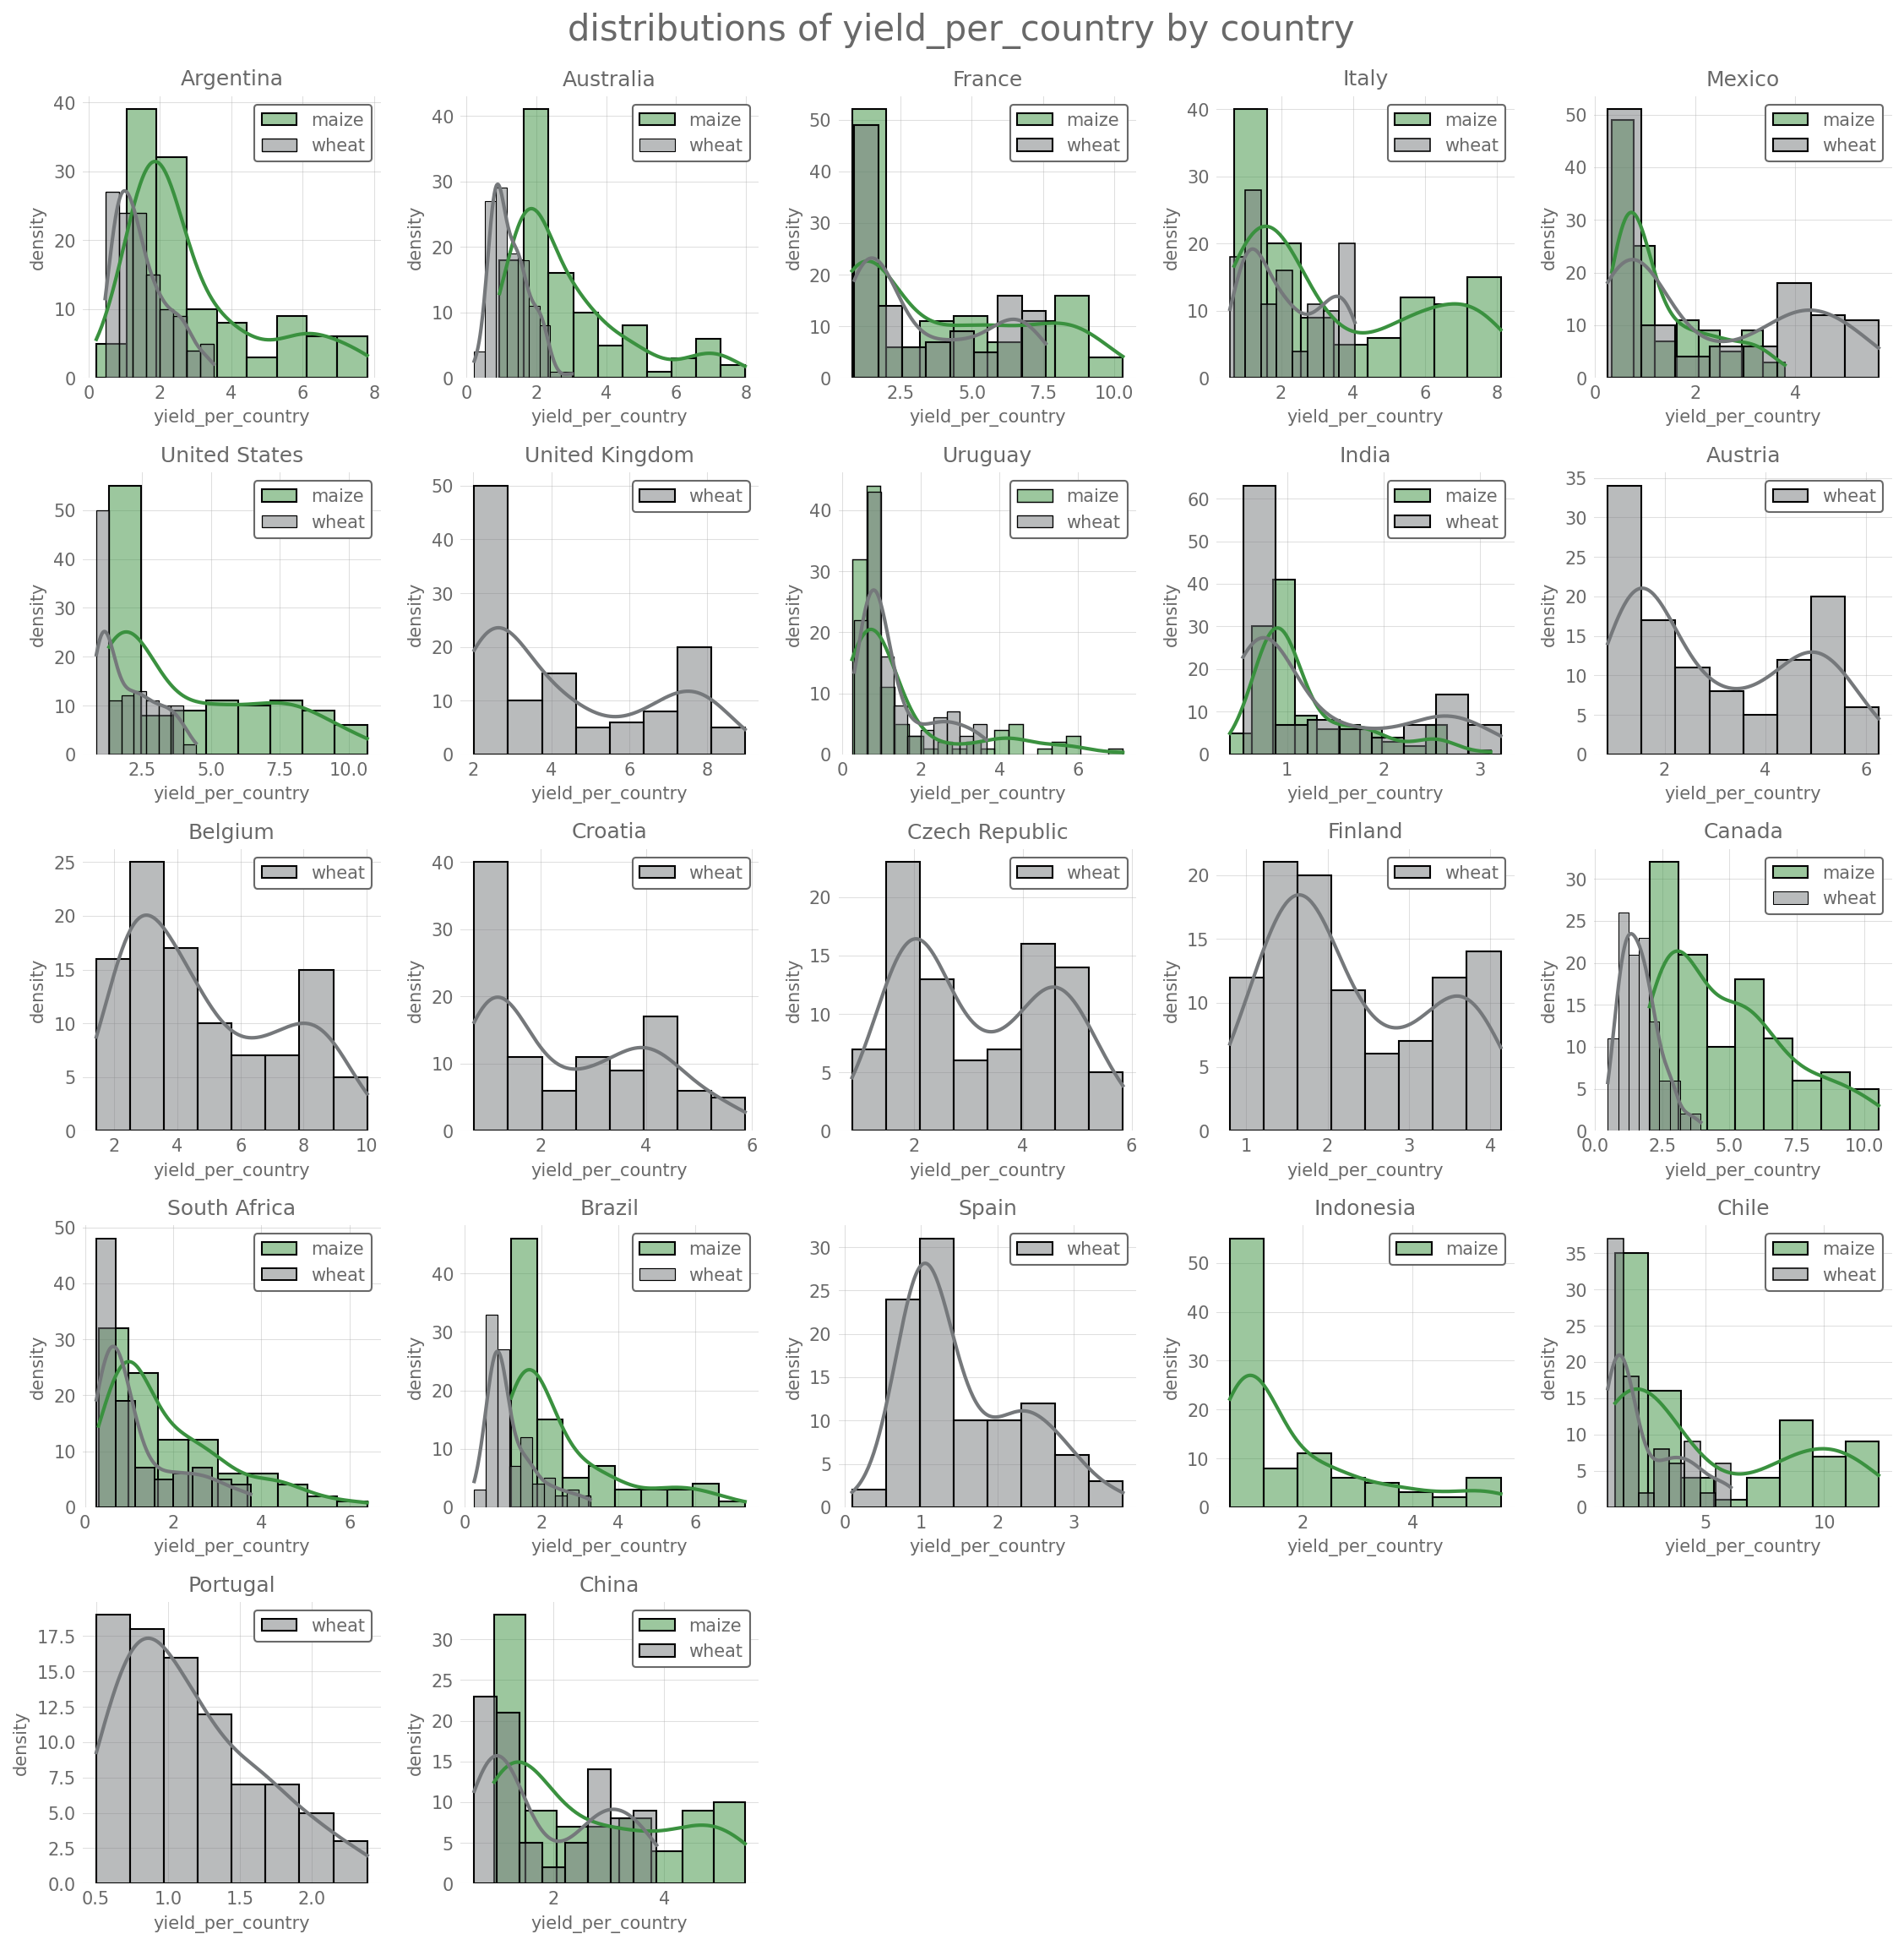

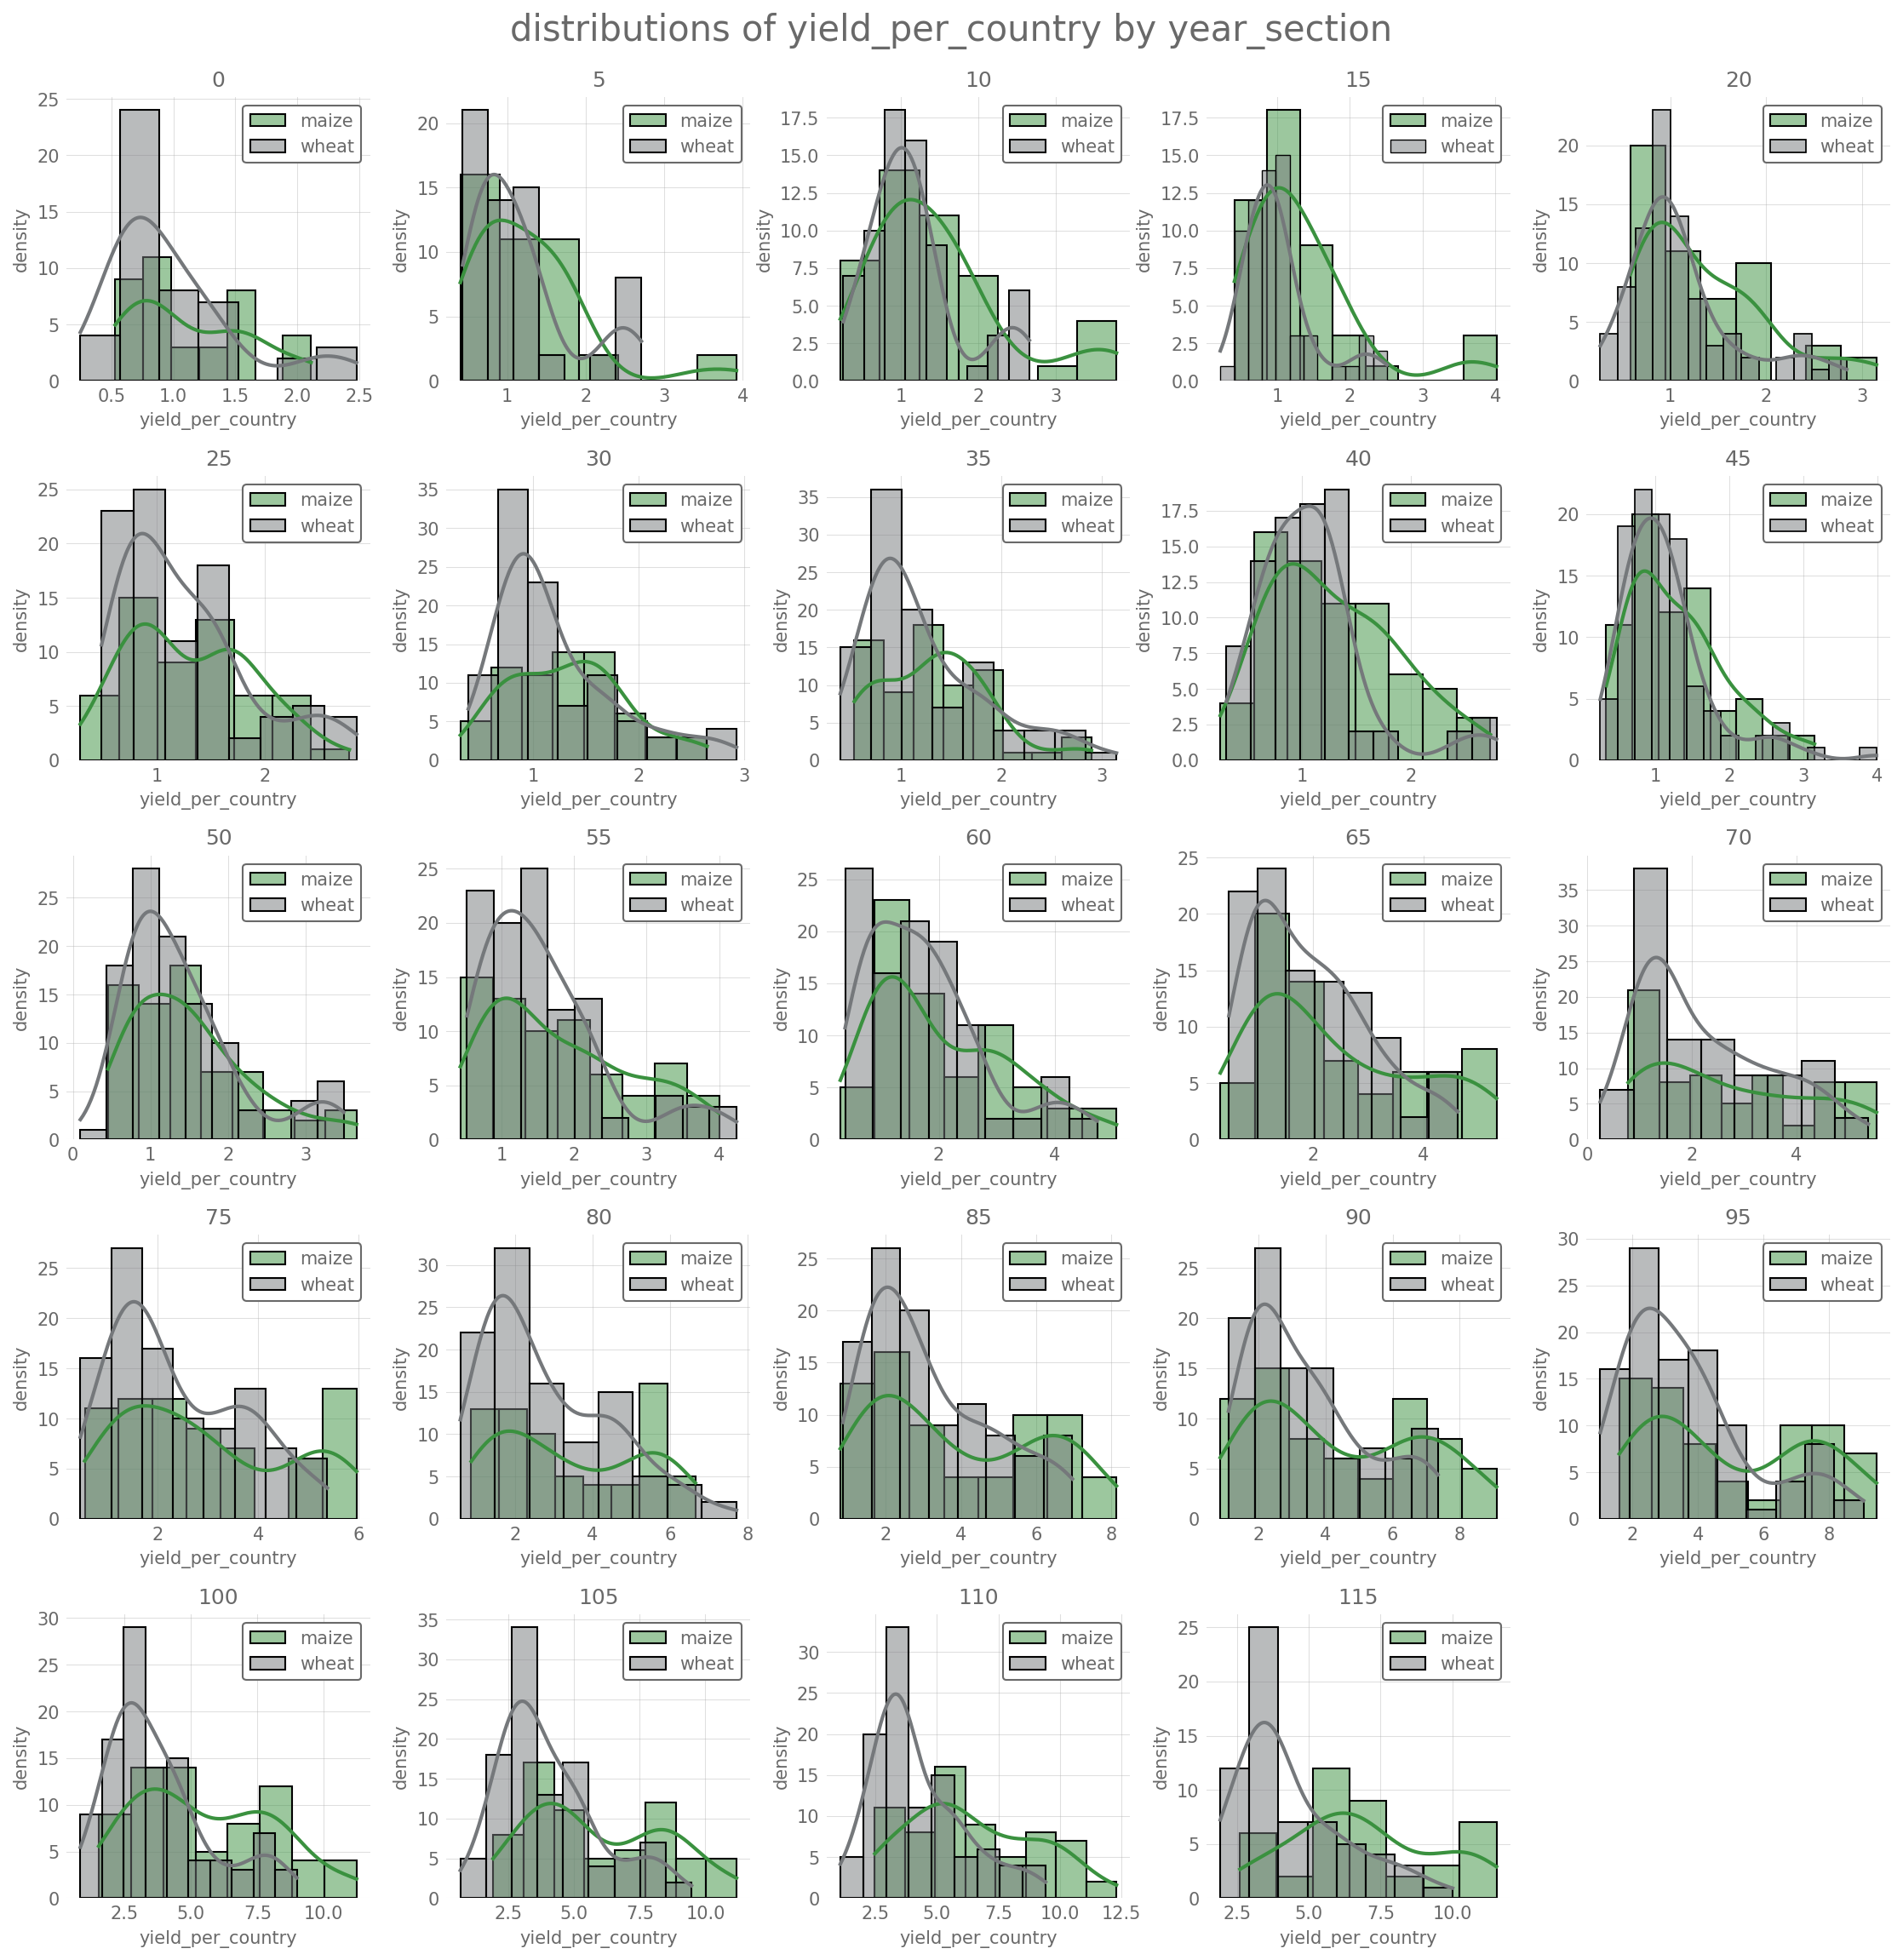

/media/nadinespy/NewVolume1/applications/ALLFED/work_trial/ALLFED-Global-Food-Shock-Analysis/src/global_food_shocks.py:235: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=data_for_group, x="year", y=y_var, hue='crop', ci=95, estimator=metric, ax=axes[i])
/media/nadinespy/NewVolume1/applications/ALLFED/work_trial/ALLFED-Global-Food-Shock-Analysis/src/global_food_shocks.py:235: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=data_for_group, x="year", y=y_var, hue='crop', ci=95, estimator=metric, ax=axes[i])
/media/nadinespy/NewVolume1/applications/ALLFED/work_trial/ALLFED-Global-Food-Shock-Analysis/src/global_food_shocks.py:235: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=data_for_group, x="year", y=y_var, hue='crop', ci=95, estimator=metric, ax=axes[i])
/media/nadinespy/Ne

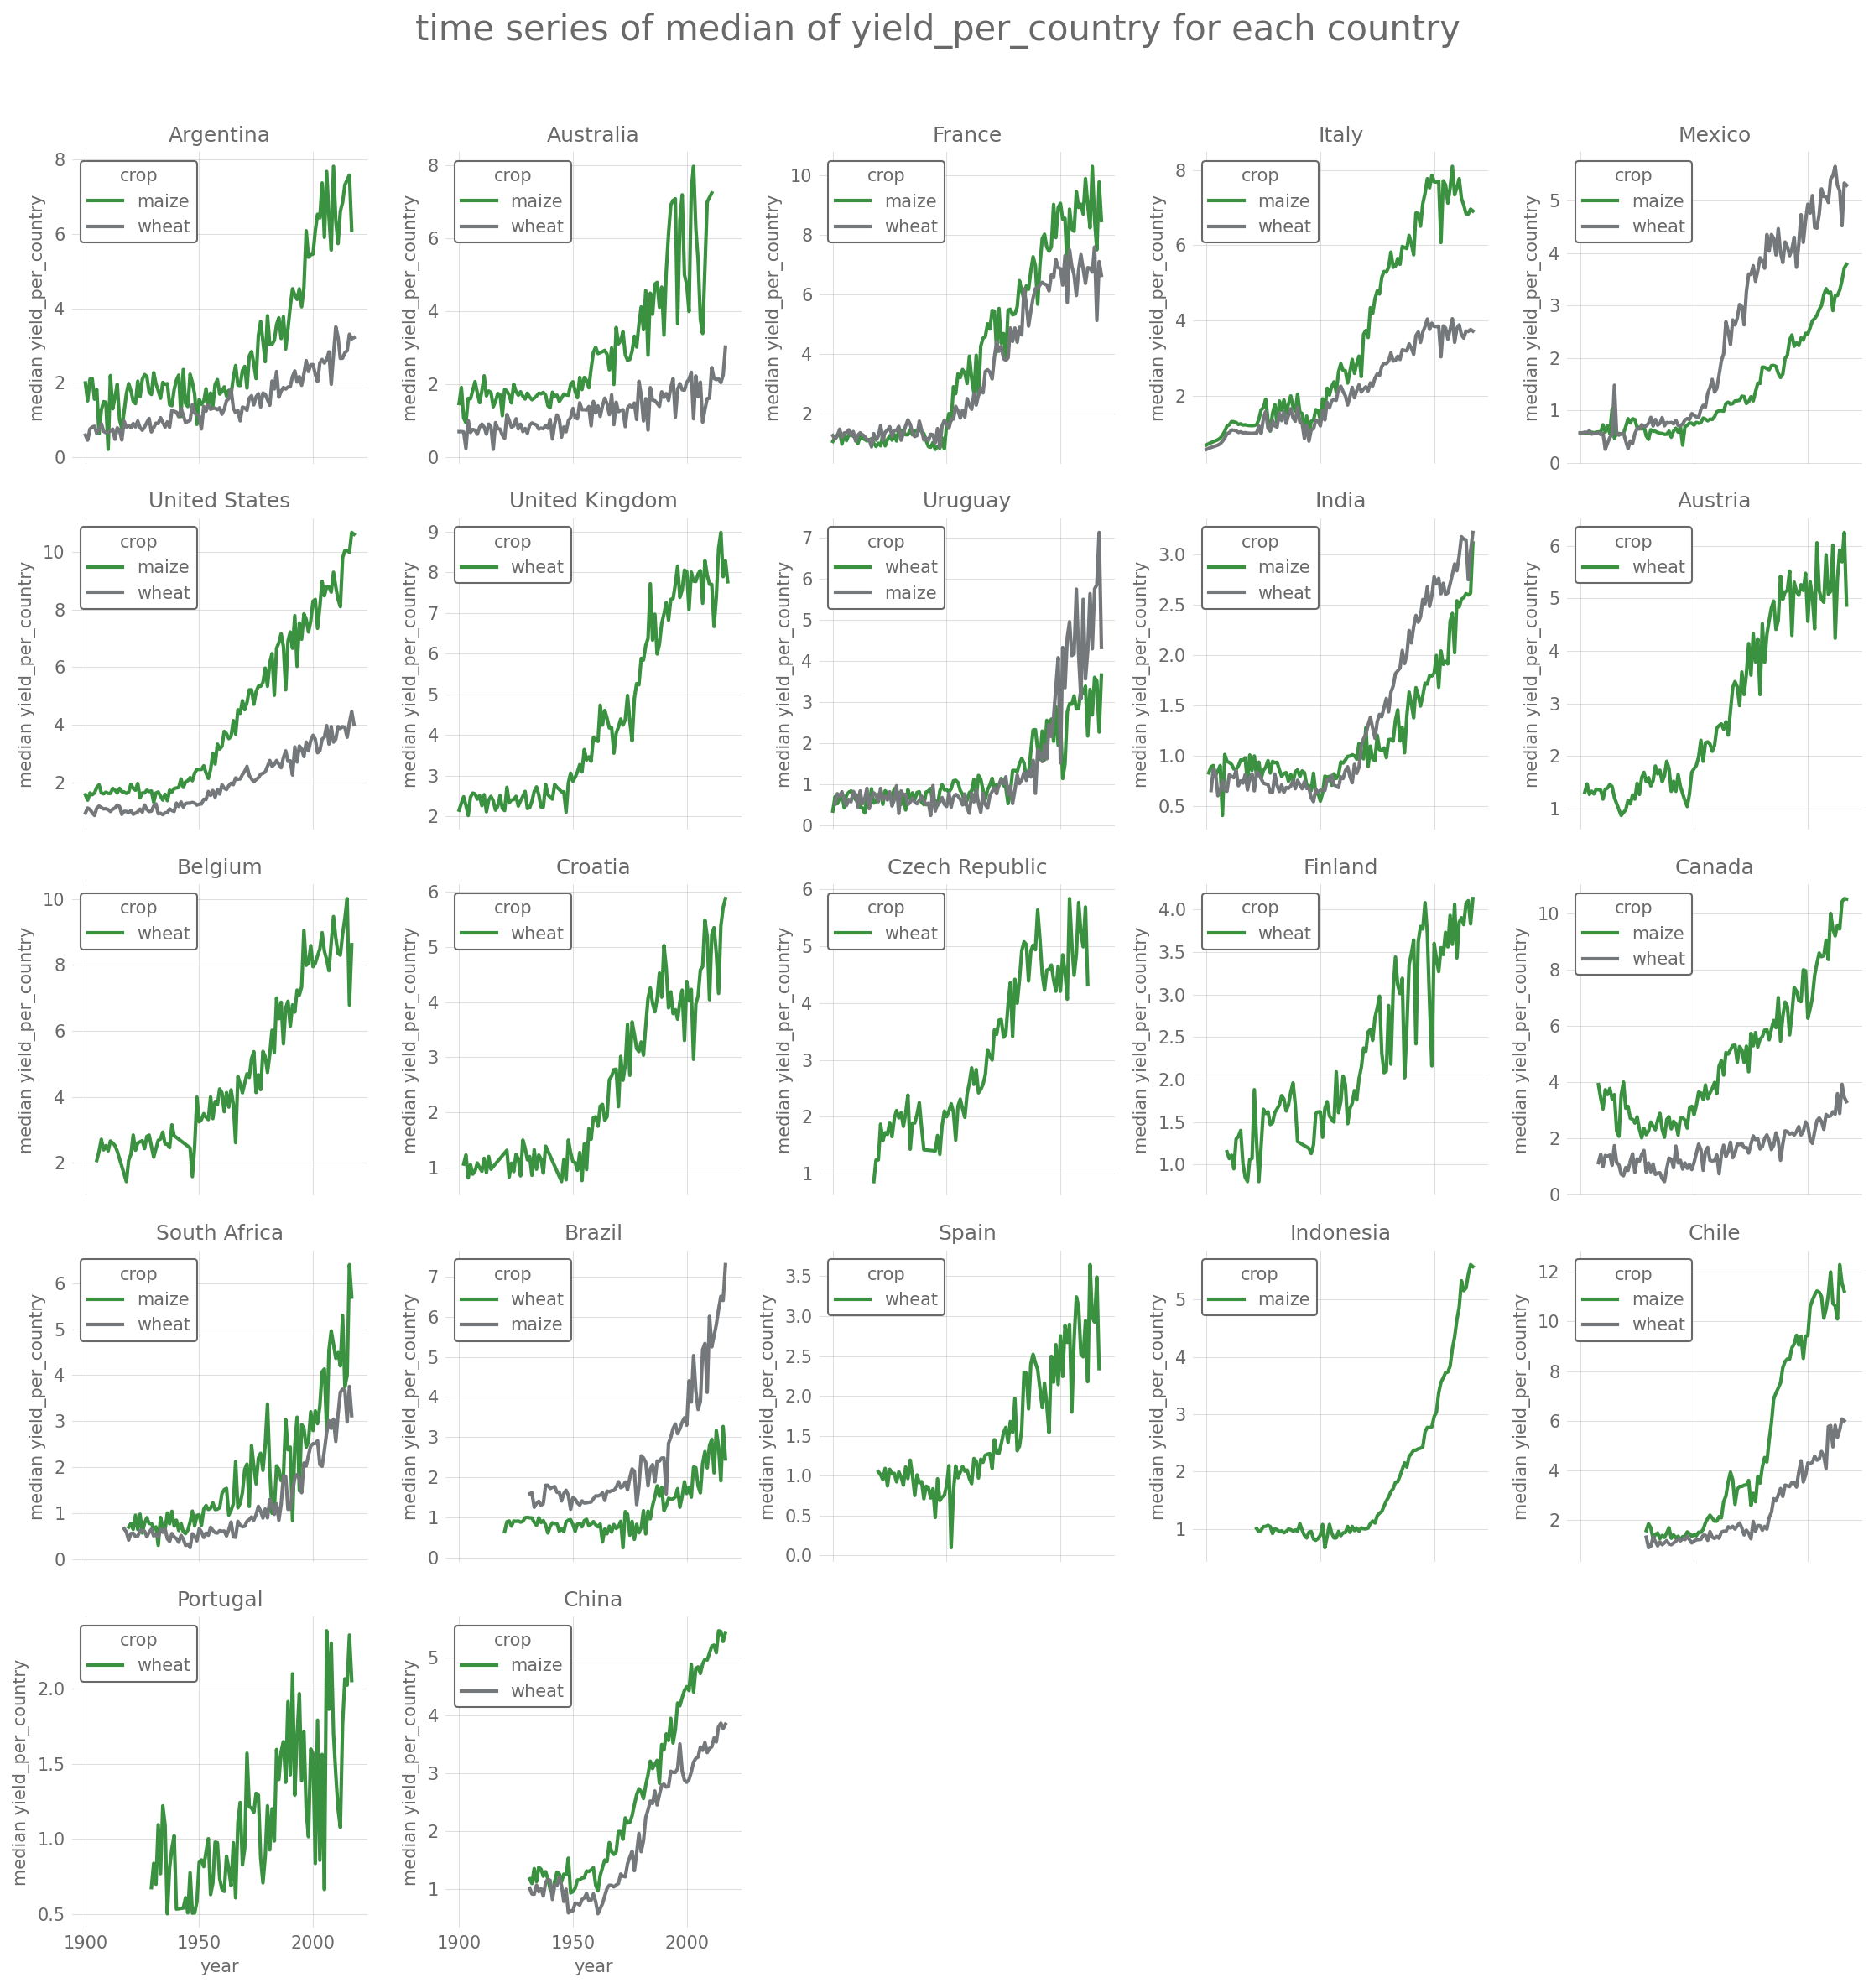

/media/nadinespy/NewVolume1/applications/ALLFED/work_trial/ALLFED-Global-Food-Shock-Analysis/src/global_food_shocks.py:213: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=df, x="year", y=y_var, hue='crop', ci=95, estimator=metric)


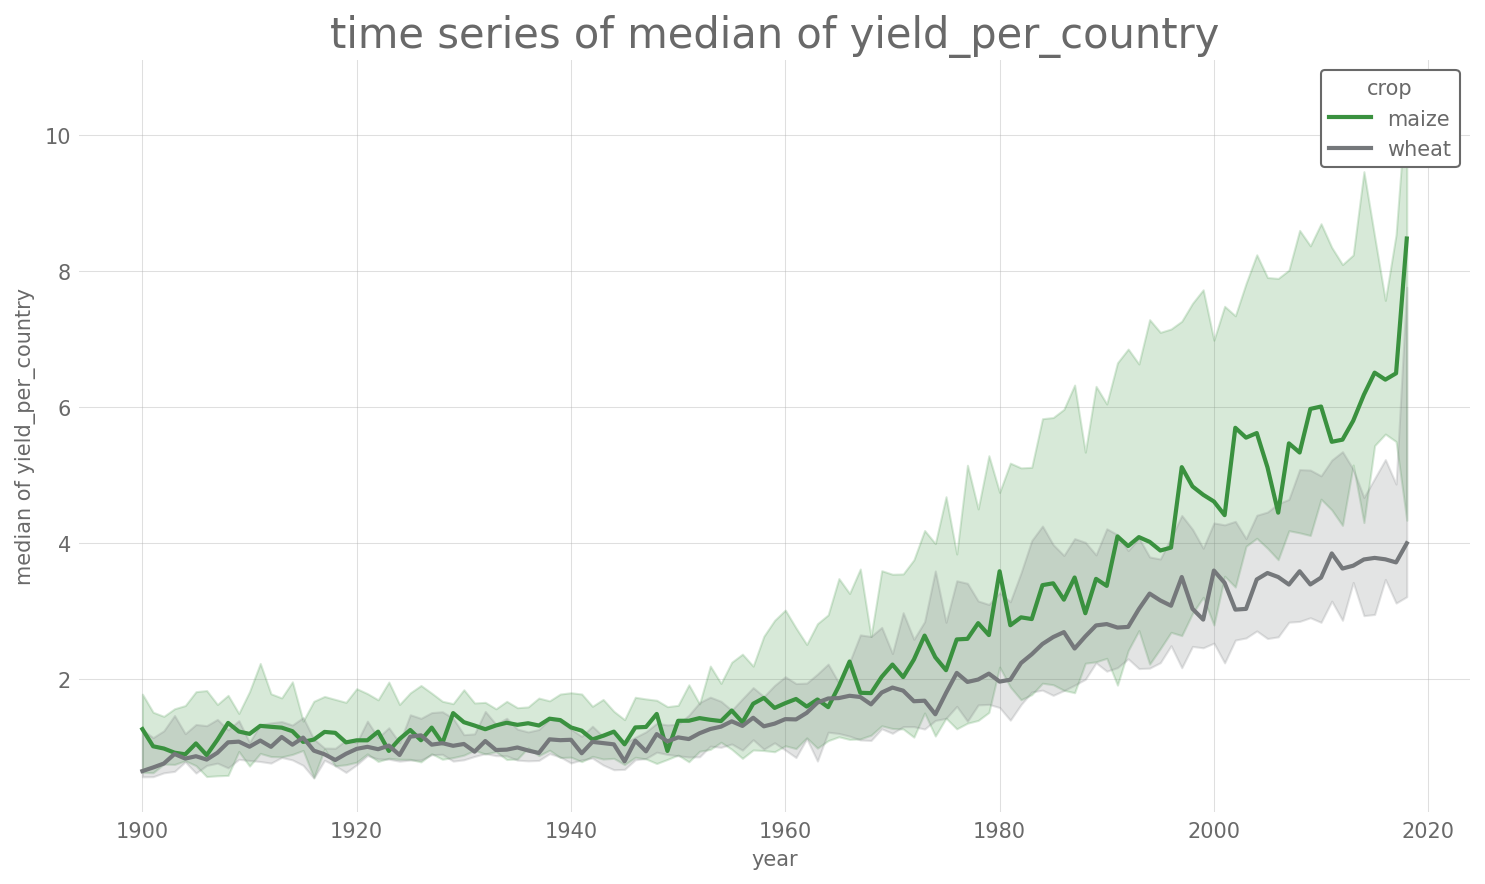

In [17]:
# calculate the median/sum values for variables of interest per country and crop for each year 
# (i.e., across regions)
vars_to_aggregate = ['yield_tonnes_per_ha', 'tonnes', 'hectares']
aggregated_vars = ['yield_per_country', 'tonnes_per_country', 'hectares_per_country']
metrics = ['median', 'sum', 'sum']
grouping_vars = ['year', 'crop', 'country']
crop_stats_country_df = gfs.compute_aggregations(crop_stats_df, vars_to_aggregate, aggregated_vars, metrics, grouping_vars)

# replace all remaining zeros and empty entries with NaNs
crop_stats_country_df = gfs.replace_values_in_columns(crop_stats_country_df, aggregated_vars, values_to_replace)

# plot barplots of missing values for variables of interest grouped by country
miss_val_per_country = gfs.calc_miss_val_percentages(crop_stats_country_df, aggregated_vars, crops, ['country'])
gfs.plot_miss_val_percentages(miss_val_per_country, aggregated_vars, crops, ['country'], pathout_plots)

# plot barplots of missing values for variables of interest grouped by year
miss_val_per_year = gfs.calc_miss_val_percentages(crop_stats_country_df, aggregated_vars, crops, ['year'])
gfs.plot_miss_val_percentages(miss_val_per_year, aggregated_vars, crops, ['year'], pathout_plots)

#--------------------------------------------------------------------------
# get distributions of yield per country across years for each country
gfs.plot_histograms(crop_stats_country_df, 'yield_per_country', 'country', crops, 5, pathout_plots)
#--------------------------------------------------------------------------

# get distributions of yield per country for each 5-year period
crop_stats_country_df['year_section'] = ((crop_stats_country_df['year'] - crop_stats_country_df['year'].min()) // 5) * 5
gfs.plot_histograms(crop_stats_country_df, 'yield_per_country', 'year_section', crops, 5, pathout_plots)

#--------------------------------------------------------------------------
# get time-series of median yield (tonnes/ha) for each country
gfs.plot_time_series_by_group(crop_stats_country_df, 'yield_per_country', pathout_plots, crops, group_var='country',
                              metric='median', num_rows=5)

#--------------------------------------------------------------------------
# get time-series of global median yield (tonnes/ha)
gfs.plot_time_series_by_group(crop_stats_country_df, 'yield_per_country', pathout_plots, crops, group_var=None,
                              metric='median', num_rows=1)


## data cleaning

We handle missing values in a simple way, i.e., by: 
- ignoring values at the start and end of the time period considered (1900-2018)/not replacing them, 
- interpolating missing values in between using linspace(), i.e., the previous existing value is taken as one end of the range, and the next existing value as the other, and a sequence of evenly spaced numbers in between is generated;
- using more complex methods such as forecasting (e. g., with AutoRegressive Integrated Moving Average (ARIMA)) or non-linear interpolation did not yield superior results (i.e., less NaNs, or better interpolation), so sticking to simple, but equally good solution

In [18]:
# create a copy of the original country dataframe
new_crop_stats_country_df = crop_stats_country_df.copy()

print('total number of NaNs before interpolation: ', new_crop_stats_country_df['yield_per_country'].isna().sum())

unique_countries = new_crop_stats_country_df['country'].unique().tolist()

for country in unique_countries:
    for crop in crops:
        mask = (new_crop_stats_country_df['country'] == country) & (new_crop_stats_country_df['crop'] == crop)

        if mask.sum() > 0:  # ensure we have rows for this country-crop combination
            original_na_count = new_crop_stats_country_df.loc[mask, 'yield_per_country'].isna().sum()
            
            # if there are NaN values, attempt interpolation
            if original_na_count > 0:
                filled_series = gfs.interpolate_series(new_crop_stats_country_df.loc[mask, 'yield_per_country'].copy())
                new_na_count = filled_series.isna().sum()

                # print to see if interpolation has been effective
                if original_na_count != new_na_count:
                    print(f"Country: {country}, Crop: {crop} - NaNs before: {original_na_count}, NaNs after: {new_na_count}")

                new_crop_stats_country_df.loc[mask, 'yield_per_country'] = filled_series

# check remaining NaNs
print('total number of NaNs after interpolation: ', new_crop_stats_country_df['yield_per_country'].isna().sum())

total number of NaNs before interpolation:  82
Interpolation occurred!
Country: Argentina, Crop: wheat - NaNs before: 1, NaNs after: 0
Interpolation occurred!
Country: Australia, Crop: maize - NaNs before: 2, NaNs after: 0
Interpolation occurred!
Country: Austria, Crop: wheat - NaNs before: 3, NaNs after: 0
Interpolation occurred!
Country: Belgium, Crop: wheat - NaNs before: 14, NaNs after: 3
Interpolation occurred!
Country: Croatia, Crop: wheat - NaNs before: 11, NaNs after: 0
Interpolation occurred!
Country: Czech Republic, Crop: wheat - NaNs before: 20, NaNs after: 16
Interpolation occurred!
Country: Finland, Crop: wheat - NaNs before: 13, NaNs after: 7
Interpolation occurred!
Country: Portugal, Crop: wheat - NaNs before: 2, NaNs after: 0
total number of NaNs after interpolation:  42


## global yield decrease analysis  

- We aggregate the country data to get a time series of global yield as well as a time series of yearly change, i.e., the change in tonnes/ha in a given year compared to the previous year. 
    - As tonnes/ha is a relative metric where country size does not play a role (but it should in a variable like global scale yield decrease), we want to use a weighting procedure: we include in our analysis only those countries that collectively contribute to 95% of the world's tonnes of crops in 2010 (the total amount of tonnes does reflect a country's size).
    - This is similar to Andersen's approach where they determined breadbasket using a 90% threshold for collective contributions to crop tonnes.

- To investigate/denote trends, we mark yield changes that fall either below or above the decile, and do a linear regression to see whether specific years or countries influence global yield change. 
    - More complex methods such as ARIMA, time series decompositions or other forecasting methods didn't seem suitable, as, given what the time-course of yearly change looks like, they would either not be reasonable, or the benefits marginal.

### aggregate country data for global scale analysis & plot new time series

/media/nadinespy/NewVolume1/applications/ALLFED/work_trial/ALLFED-Global-Food-Shock-Analysis/src/global_food_shocks.py:235: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=data_for_group, x="year", y=y_var, hue='crop', ci=95, estimator=metric, ax=axes[i])
/media/nadinespy/NewVolume1/applications/ALLFED/work_trial/ALLFED-Global-Food-Shock-Analysis/src/global_food_shocks.py:235: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=data_for_group, x="year", y=y_var, hue='crop', ci=95, estimator=metric, ax=axes[i])
/media/nadinespy/NewVolume1/applications/ALLFED/work_trial/ALLFED-Global-Food-Shock-Analysis/src/global_food_shocks.py:235: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=data_for_group, x="year", y=y_var, hue='crop', ci=95, estimator=metric, ax=axes[i])
/media/nadinespy/Ne

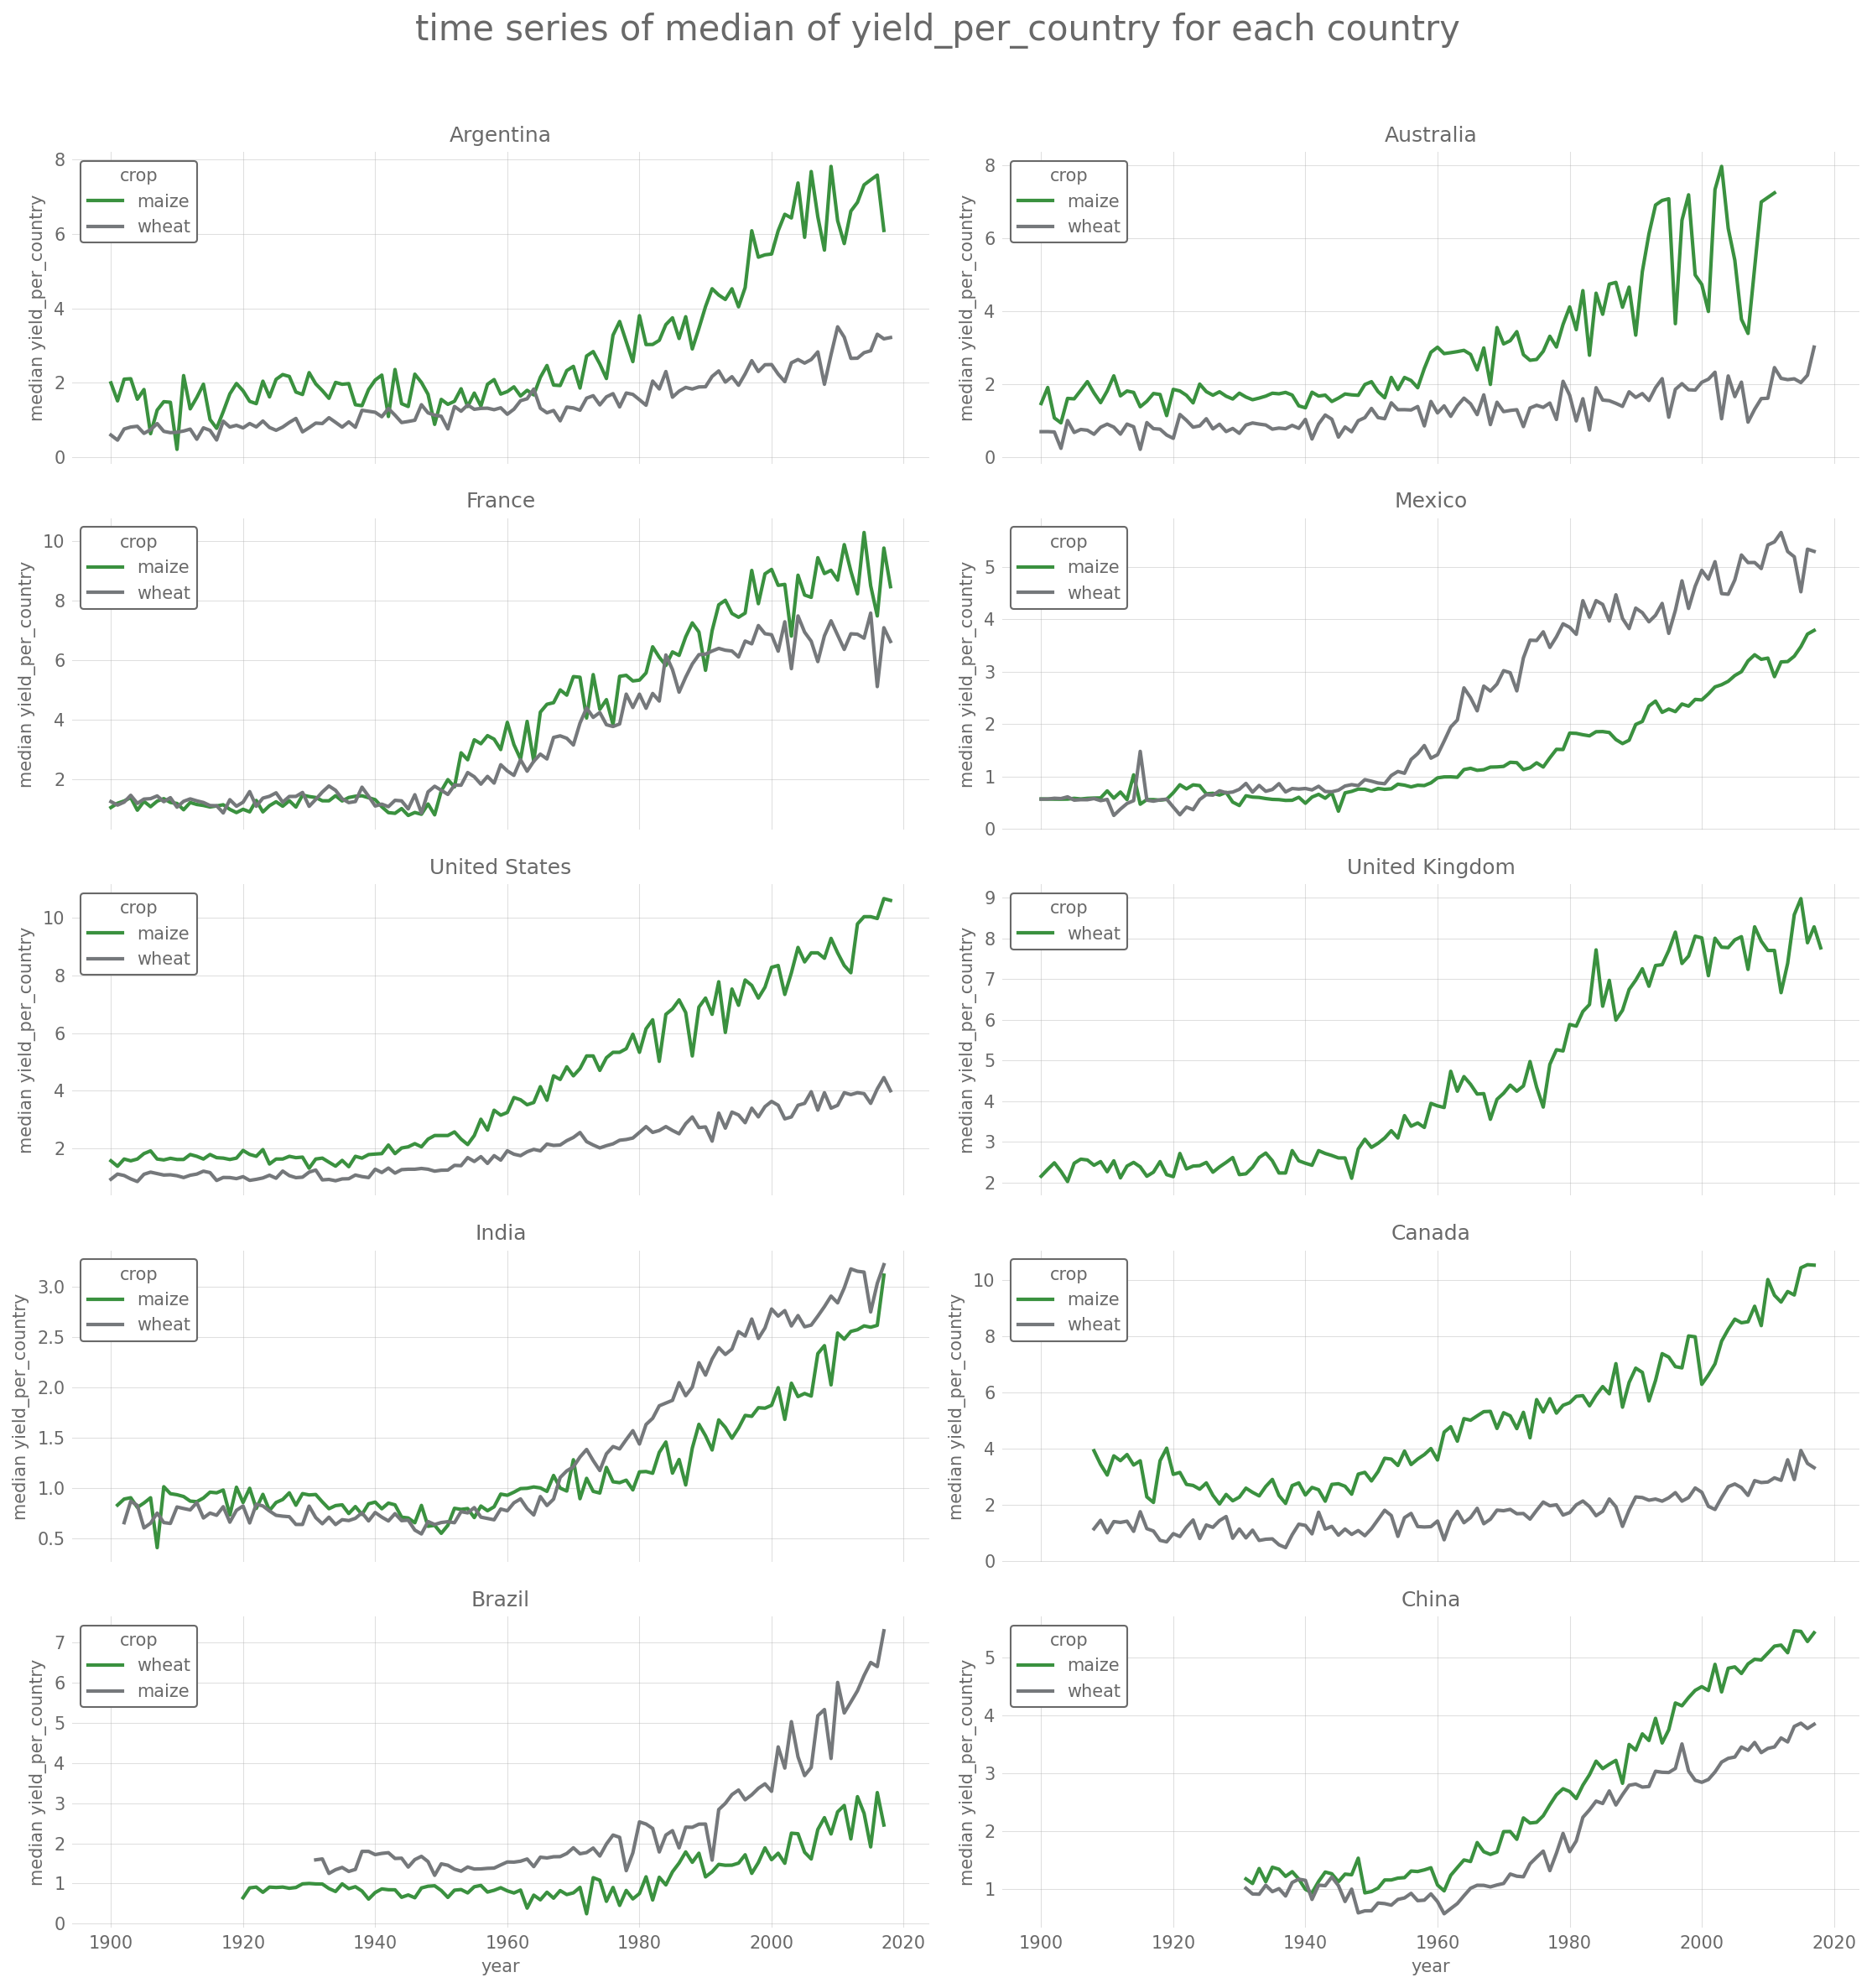

/media/nadinespy/NewVolume1/applications/ALLFED/work_trial/ALLFED-Global-Food-Shock-Analysis/src/global_food_shocks.py:213: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=df, x="year", y=y_var, hue='crop', ci=95, estimator=metric)


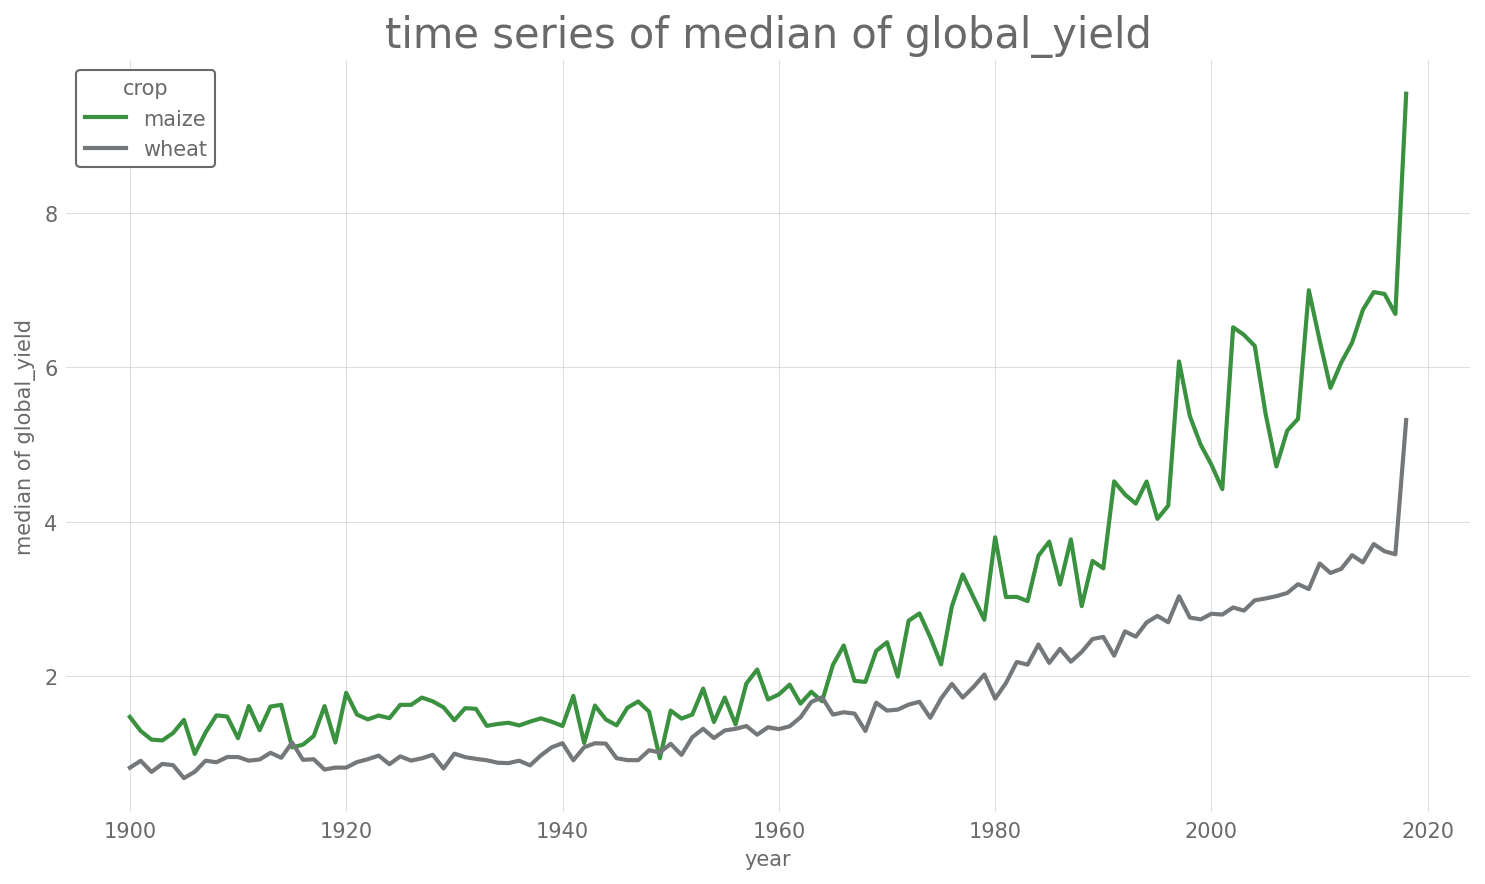

In [19]:
# include country in analysis only if it contributes to 95% of crop yield (tonnes) in 2010
new_crop_stats_country_df_2010 = new_crop_stats_country_df[new_crop_stats_country_df['year'] == 2010]
total_tonnes_by_country = new_crop_stats_country_df_2010.groupby(
    'country')['tonnes_per_country'].sum().sort_values(ascending=False) # calculate total tonnes by country for 2010
cumsum_tonnes = total_tonnes_by_country.cumsum()                        # calculate cumulative sum
cutoff_90_percent = total_tonnes_by_country.sum() * 0.95                # determine 95% cutoff
top_countries = cumsum_tonnes[cumsum_tonnes <= cutoff_90_percent].index # get countries that make up the first 90%
new_crop_stats_country_df = new_crop_stats_country_df[new_crop_stats_country_df['country'].isin(top_countries)]

# calculate the median/sum values for variables of interest per crop for each year across countries
variables_to_compute = ['yield_per_country']
new_variable_names = ['global_yield']
metrics = ['median']
grouping_columns = ['year', 'crop']
new_crop_stats_global_df = gfs.compute_aggregations(new_crop_stats_country_df, variables_to_compute, new_variable_names, metrics, grouping_columns)

# get new time-series of yield (tonnes/ha) per country for new list of countries
gfs.plot_time_series_by_group(new_crop_stats_country_df, 'yield_per_country', pathout_plots, crops, group_var='country',
                              metric='median',num_rows=5)

# get new time-series of global yield (tonnes/ha) for new list of countries
gfs.plot_time_series_by_group(new_crop_stats_global_df, 'global_yield', pathout_plots, crops,
                              metric='median',num_rows=5)

### yearly change in global yield

/tmp/ipykernel_898757/1024565588.py:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=new_crop_stats_global_df, x="year", y="global_yield_change", hue="crop", ci=95)


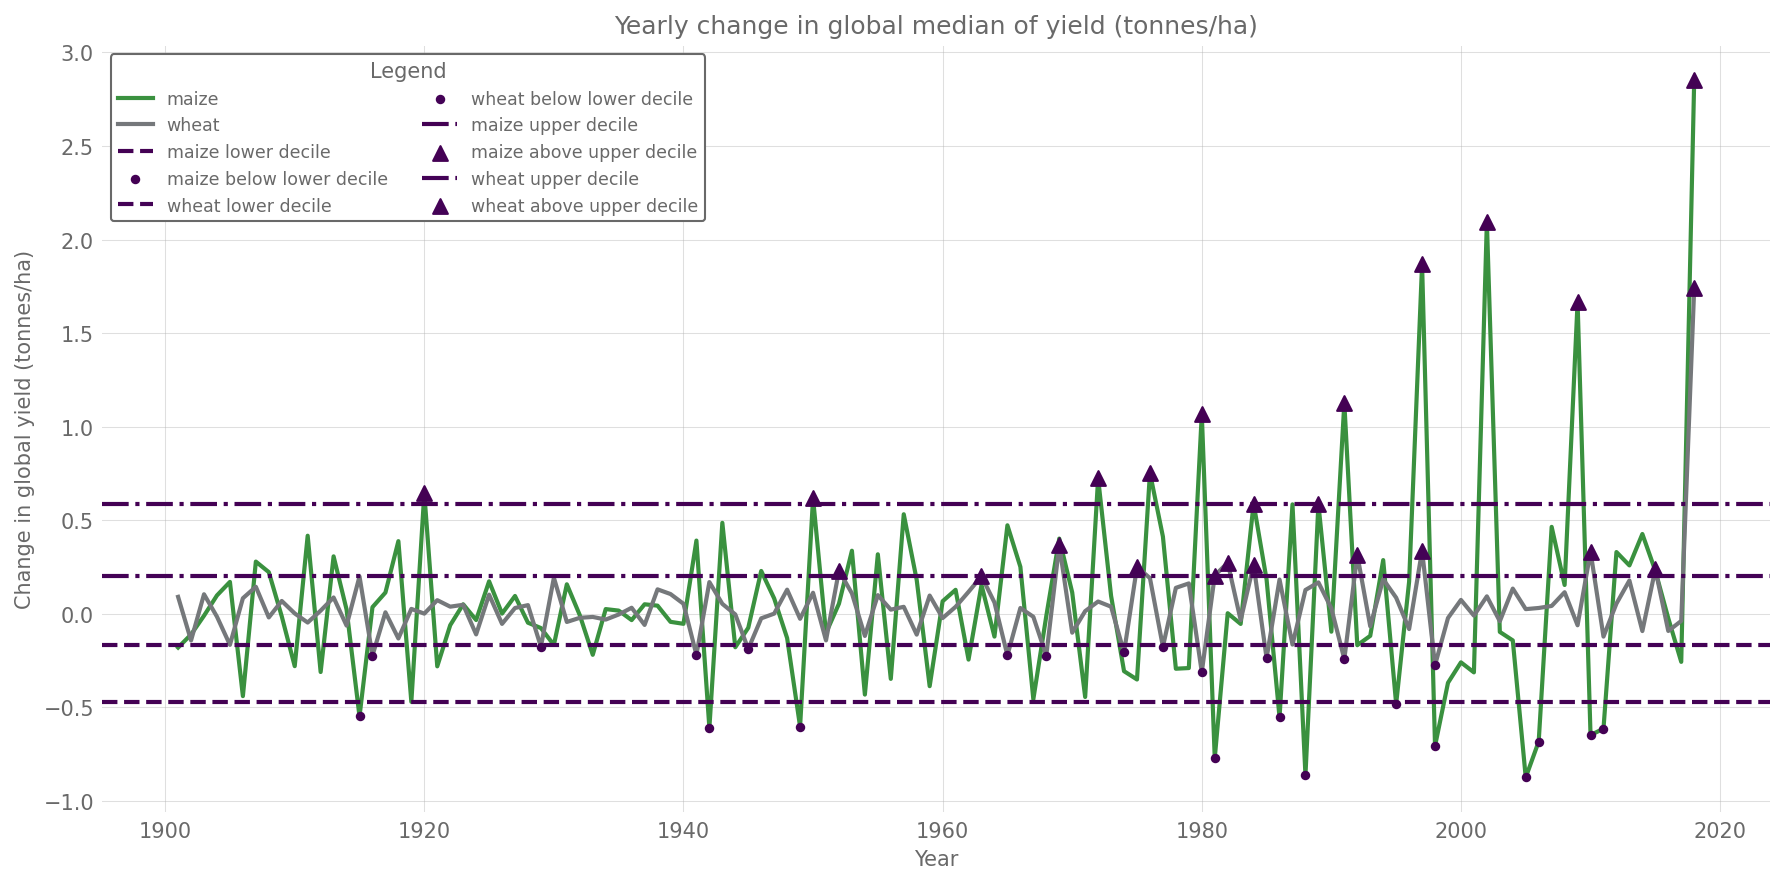

In [20]:
# calculate yearly change
new_crop_stats_global_df['global_yield_change'] = new_crop_stats_global_df.sort_values("year", ascending=True).groupby('crop')['global_yield'].diff()
new_crop_stats_global_df = new_crop_stats_global_df[new_crop_stats_global_df['year'] != 1900]

# create a dictionary to map each crop to a unique index
crop_to_index = {crop: i for i, crop in enumerate(new_crop_stats_global_df['crop'].unique())}
color_map = plt.get_cmap()

plt.figure(figsize=(12, 6))

# calculate the lower and upper deciles for each crop
lower_deciles = new_crop_stats_global_df.groupby('crop')['global_yield_change'].quantile(0.1).to_dict()
upper_deciles = new_crop_stats_global_df.groupby('crop')['global_yield_change'].quantile(0.9).to_dict()

# plotting the main lineplot
sns.lineplot(data=new_crop_stats_global_df, x="year", y="global_yield_change", hue="crop", ci=95)

# adding horizontal lines and highlighting instances within the lower and upper deciles
dot_size = 50
for crop, decile in lower_deciles.items():
    plt.axhline(decile, color=color_map(crop_to_index[crop]), linestyle='--', label=f"{crop} lower decile")
    below_decile = new_crop_stats_global_df[(new_crop_stats_global_df['crop'] == crop) & (new_crop_stats_global_df['global_yield_change'] < decile)]
    plt.scatter(below_decile['year'], below_decile['global_yield_change'], color=color_map(crop_to_index[crop]), zorder=5, s=dot_size, label=f"{crop} below lower decile")
    
for crop, decile in upper_deciles.items():
    plt.axhline(decile, color=color_map(crop_to_index[crop]), linestyle='-.', label=f"{crop} upper decile")
    above_decile = new_crop_stats_global_df[(new_crop_stats_global_df['crop'] == crop) & (new_crop_stats_global_df['global_yield_change'] > decile)]
    plt.scatter(above_decile['year'], above_decile['global_yield_change'], color=color_map(crop_to_index[crop]), zorder=5, s=dot_size, marker="^", label=f"{crop} above upper decile")

plt.title('Yearly change in global median of yield (tonnes/ha)')
plt.xlabel('Year')
plt.ylabel('Change in global yield (tonnes/ha)')
plt.legend(title="Legend", loc="upper left", fontsize='small', ncol=2)
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{pathout_plots}median_global_yield_change_over_years.png", bbox_inches='tight', dpi=300)

plt.show()


### distribution of global food decrease

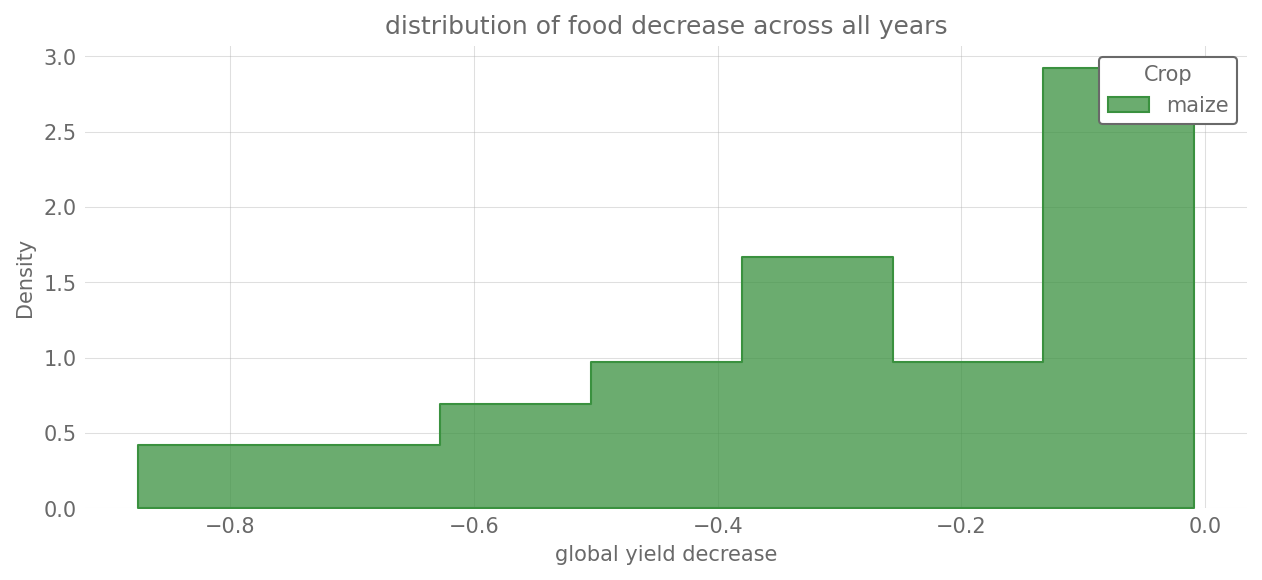

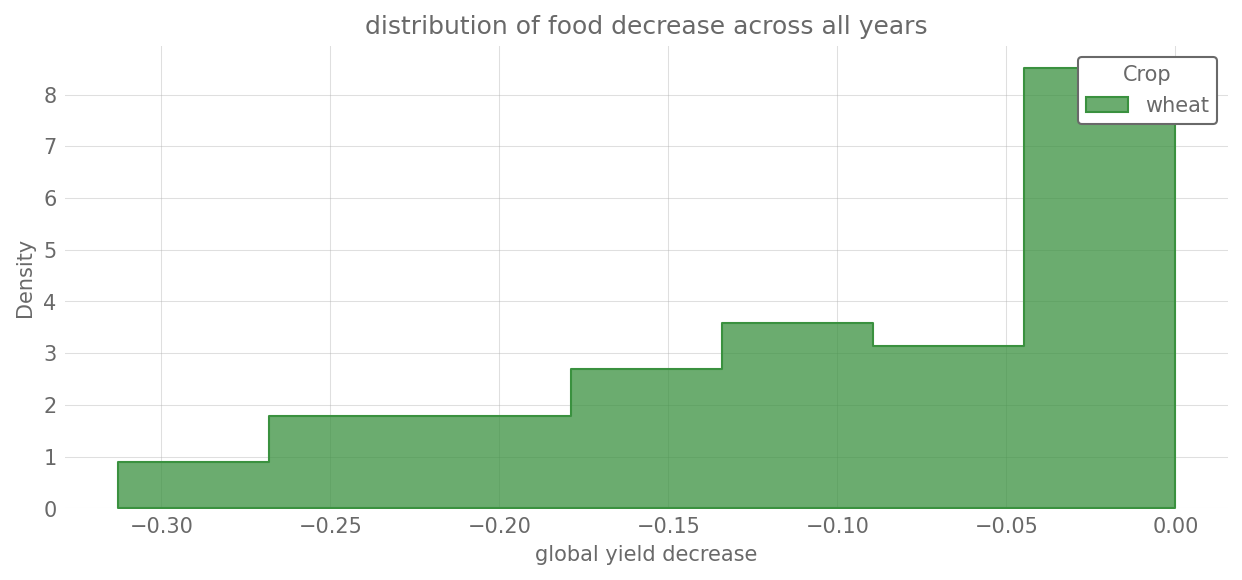

In [21]:
for crop in crops:
    subset = new_crop_stats_global_df[(new_crop_stats_global_df['crop'] == crop) & (new_crop_stats_global_df['global_yield_change'] < 0)]
    sns.histplot(data=subset, x="global_yield_change", label=crop, element="step", stat="density")

    plt.title('distribution of food decrease across all years')
    plt.xlabel('global yield decrease')
    plt.ylabel('Density')
    plt.legend(title="Crop")

    plt.savefig(f"{pathout_plots}distr_food_shocks_{crop}.png", bbox_inches='tight', dpi=300)
    plt.show()


### world map with largest food decrease per country

/tmp/ipykernel_898757/157027976.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


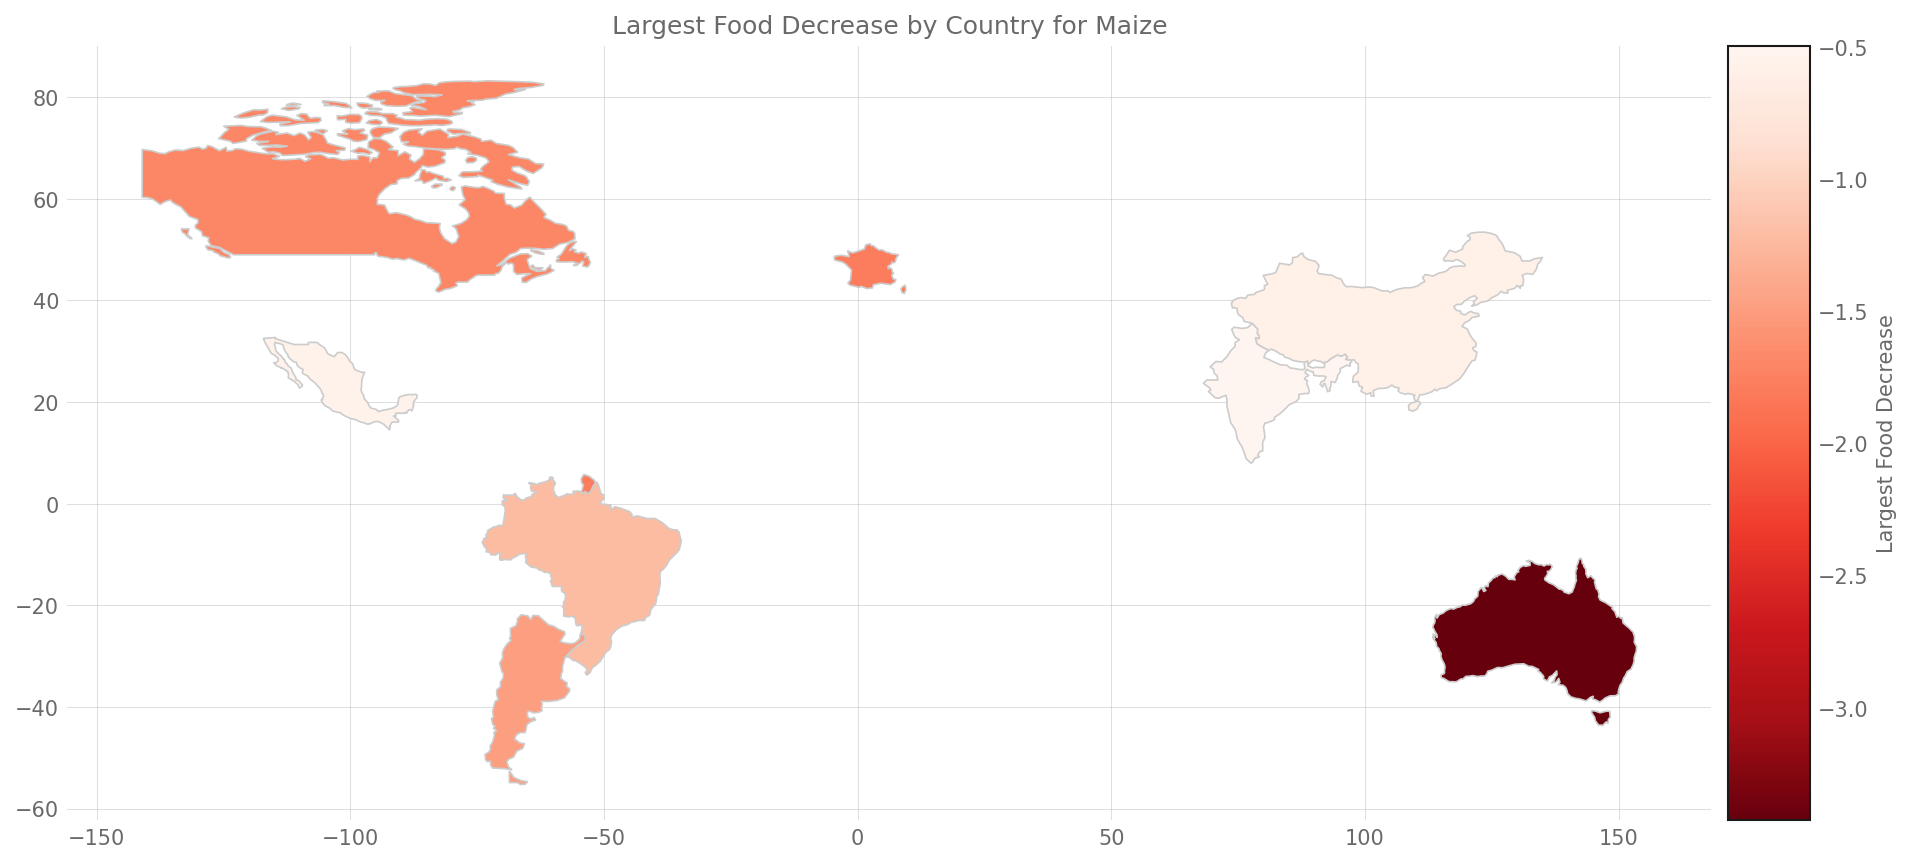

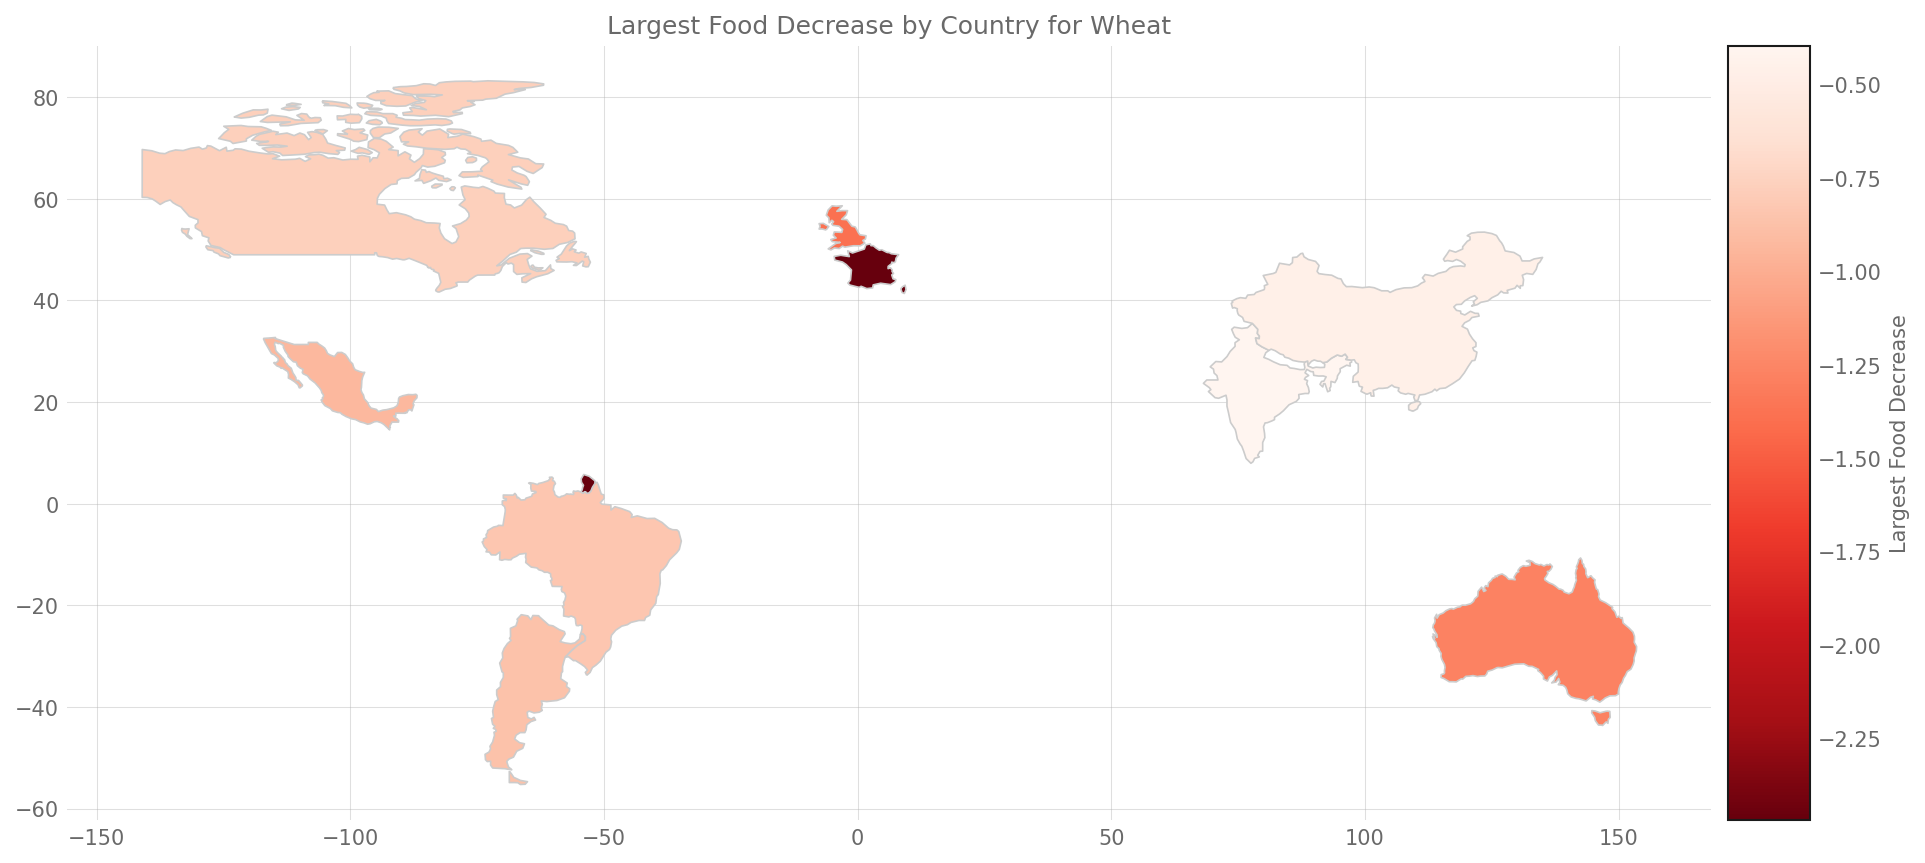

In [22]:
# get yearly change in crop yield per country (separate for wheat and maize)
new_crop_stats_country_df['yearly_yield_change'] = new_crop_stats_country_df.groupby(['crop', 'country'])['yield_per_country'].diff()

# load the world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# loop through each crop type
for crop in crops: 

    # finding the largest decrease (food shock) for the specific crop
    largest_decreases = new_crop_stats_country_df[new_crop_stats_country_df['crop'] == crop].groupby('country')['yearly_yield_change'].min().reset_index()

    # merge the world map with the largest decreases data for the specific crop
    merged = world.set_index('name').join(largest_decreases.set_index('country'))

    # setup figure and axis
    fig, ax = plt.subplots(1, 1, figsize=(15, 25))

    # adjust colorbar size and add a label
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    merged.plot(column='yearly_yield_change', cmap='Reds_r', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, cax=cax)
    cax.set_ylabel('Largest Food Decrease')

    ax.set_title(f'Largest Food Decrease by Country for {crop.capitalize()}')
    plt.savefig(f"{pathout_plots}max_food_shock_{crop}.png", bbox_inches='tight', dpi=300)
    
    plt.show()

### trends/patterns & anomalies


Conclusions
Caveats in this analysis
What could I have done differently?